In [1]:
in_colab = False
try:
    import google.colab
    in_colab = True
except:
    in_colab = False
in_colab

True

In [2]:
if in_colab:
  !pip install neurokit2
  !pip install torchinfo
  !pip install pytorch_lightning
  !pip install wfdb
  #!pip install ssqueezepy
  !pip install pycwt
  #!pip install matplotlib==3.8
  #!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 51.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [3]:
import torch
from torch import optim, nn
from IPython.display import clear_output
from torchinfo import summary
import neurokit2 as nk
from sklearn.decomposition import PCA
from plotly import graph_objects as go
import os
import pywt as pw
from math import ceil
import cv2
from matplotlib import cm
from matplotlib import rcParams
import pytorch_lightning as pl
import imageio
import gc
import collections
from pytorch_lightning.loggers import Logger
from pytorch_lightning.loggers.logger import rank_zero_experiment
from pytorch_lightning.utilities import rank_zero_only
import scipy
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import ast
import os
import warnings
import numpy as np
import math
from torch.utils.data import DataLoader, Dataset
import cv2 as cv
from scipy.signal import butter, lfilter, iirnotch

gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

warnings.simplefilter(action='ignore', category=FutureWarning)
rcParams['font.weight'] = 'bold'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
channels = ["I", "II", "III", "aVL", "aVR", "aVF", "V1", "V2", "V3", "V4", "V5", "V6" ]
channels_map = {idx: channel for idx, channel in enumerate(channels)}

In [5]:
!python --version

Python 3.10.12


In [6]:
torch.__version__

'2.2.1+cu121'

In [7]:
torch.cuda.is_available()

True

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [9]:
%matplotlib inline

In [10]:
map_superclass_rev = {'CD': 0, 'HYP': 1, 'MI': 2, 'NORM': 3, 'STTC': 4}

In [11]:
if in_colab:
  from google.colab import drive
  drive.mount("/content/drive/", force_remount = True)
  %cd "drive/MyDrive/Colab Notebooks/ECG_SuperResolution"

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/ECG_SuperResolution


In [ ]:
cwd = os.getcwd() + os.sep
path = cwd+"data"+os.sep+"PTBXL"+os.sep+"rawdata"+os.sep#"data\\1d\\PTBXL"+os.sep #your dataset path here
filename = path + "ptbxl_database.csv"
df = pd.read_csv(filename, sep=",", index_col="ecg_id")
df.head(20)

patient_id   age  sex  height  weight  nurse  site     device  \
ecg_id                                                                  
1          15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
2          13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
3          20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
4          17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
5          17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   
6          19005.0  18.0    1     NaN    58.0    2.0   0.0  CS-12   E   
7          16193.0  54.0    0     NaN    83.0    2.0   0.0  CS-12   E   
8          11275.0  48.0    0     NaN    95.0    2.0   0.0  CS-12   E   
9          18792.0  55.0    0     NaN    70.0    2.0   0.0  CS-12   E   
10          9456.0  22.0    1     NaN    56.0    2.0   0.0  CS-12   E   
11         11243.0  20.0    1     NaN    57.0    2.0   0.0  CS-12   E   
12         11031.0  43.0    1     NaN    44.0    2.0   0.0  CS-12   E   
13         19953.0  58.0    1     NaN    54.0    2.0   0.0  CS-12   E   
14         12925.0  19.0    1     NaN    58.0    2.0   0.0  CS-12   E   
15         13375.0  17.0    1     NaN    67.0    2.0   0.0  CS-12   E   
16         10999.0  49.0    0     NaN    79.0    2.0   0.0  CS-12   E   
17         13619.0  56.0    0     NaN     NaN    2.0   0.0  CS-12   E   
18         13619.0  56.0    0     NaN     NaN    2.0   0.0  CS-12   E   
19         11116.0  20.0    0     NaN    85.0    2.0   0.0  CS-12   E   
20         13619.0  56.0    0     NaN     NaN    2.0   0.0  CS-12   E   

             recording_date  \
ecg_id                        
1       1984-11-09 09:17:34   
2       1984-11-14 12:55:37   
3       1984-11-15 12:49:10   
4       1984-11-15 13:44:57   
5       1984-11-17 10:43:15   
6       1984-11-28 13:32:13   
7       1984-11-28 13:32:22   
8       1984-12-01 14:49:52   
9       1984-12-08 09:44:43   
10      1984-12-12 14:12:46   
11      1984-12-16 14:20:39   
12      1984-12-21 08:02:26   
13      1985-01-05 12:13:05   
14      1985-01-10 11:45:19   
15      1985-01-12 10:39:41   
16      1985-01-16 08:27:38   
17      1985-01-20 14:25:25   
18      1985-01-20 15:17:24   
19      1985-01-23 11:23:00   
20      1985-01-23 12:55:32   

                                                   report  ...  \
ecg_id                                                     ...   
1                  sinusrhythmus periphere niederspannung  ...   
2                     sinusbradykardie sonst normales ekg  ...   
3                              sinusrhythmus normales ekg  ...   
4                              sinusrhythmus normales ekg  ...   
5                              sinusrhythmus normales ekg  ...   
6                              sinusrhythmus normales ekg  ...   
7       sinusrhythmus linkstyp t abnormal, wahrscheinl...  ...   
8       sinusrhythmus linkstyp qrs(t) abnormal    infe...  ...   
9                              sinusrhythmus normales ekg  ...   
10                             sinusrhythmus normales ekg  ...   
11                    sinus arrhythmie sonst normales ekg  ...   
12                    sinusbradykardie sonst normales ekg  ...   
13                             sinusrhythmus normales ekg  ...   
14                             sinusrhythmus normales ekg  ...   
15                    sinus arrhythmie sonst normales ekg  ...   
16                             sinusrhythmus normales ekg  ...   
17      vorhof:hf  280 tachykardes vorhofflimmern uebe...  ...   
18      vorhofflattern 2:1 Überleitung,jetzt nach isop...  ...   
19                          sinusrhythmus p-verbreiterung  ...   
20      supraventrikulÄre ersatzsystole(n) interponier...  ...   

       validated_by_human  baseline_drift static_noise burst_noise  \
ecg_id                                                               
1                    True             NaN    , I-V1,           NaN   
2                    True             NaN          NaN 

In [ ]:
n, m = df.shape
n, m

(21799, 27)

In [ ]:
columns = df.columns
map_columns = {column: i for i, column in enumerate(columns)}
map_columns

{'patient_id': 0,
 'age': 1,
 'sex': 2,
 'height': 3,
 'weight': 4,
 'nurse': 5,
 'site': 6,
 'device': 7,
 'recording_date': 8,
 'report': 9,
 'scp_codes': 10,
 'heart_axis': 11,
 'infarction_stadium1': 12,
 'infarction_stadium2': 13,
 'validated_by': 14,
 'second_opinion': 15,
 'initial_autogenerated_report': 16,
 'validated_by_human': 17,
 'baseline_drift': 18,
 'static_noise': 19,
 'burst_noise': 20,
 'electrodes_problems': 21,
 'extra_beats': 22,
 'pacemaker': 23,
 'strat_fold': 24,
 'filename_lr': 25,
 'filename_hr': 26}

In [ ]:
files =  list(df["filename_hr"].values)

In [ ]:
noisy_files = []
for i in range(n):

    print(i , end=" \r")
    row = df.iloc[i, :]
    filenamehr = row["filename_hr"]
    baselinedrift = row["baseline_drift"]
    staticnoise = row["static_noise"]
    electrodesproblems = row["electrodes_problems"]
    burstnoise = row["burst_noise"]
    if isinstance(baselinedrift, str) or isinstance(staticnoise, str)  or isinstance(electrodesproblems, str)  or isinstance(burstnoise, str):
        #print(baselinedrift, type(baselinedrift), staticnoise, type(staticnoise))
        noisy_files.append(filenamehr)

In [ ]:
len(noisy_files)

5010

In [ ]:
files_no_noise = np.setdiff1d(files, noisy_files)
files_no_noise

array(['records500/00000/00002_hr', 'records500/00000/00003_hr',
       'records500/00000/00007_hr', ..., 'records500/21000/21832_hr',
       'records500/21000/21834_hr', 'records500/21000/21836_hr'],
      dtype='<U25')

In [ ]:
seconds = 10
nchs = 12
fs_lr = 100
fs_hr = 500
lenght_lr = fs_lr*seconds
lenght_hr = fs_hr*seconds

In [ ]:
len(files_no_noise)

16789

In [ ]:
newdf = df.copy()
for file in noisy_files:
    newdf = newdf[newdf["filename_hr"] != file]

In [ ]:
newdf.head(10)

patient_id   age  sex  height  weight  nurse  site     device  \
ecg_id                                                                  
2          13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
3          20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
7          16193.0  54.0    0     NaN    83.0    2.0   0.0  CS-12   E   
10          9456.0  22.0    1     NaN    56.0    2.0   0.0  CS-12   E   
12         11031.0  43.0    1     NaN    44.0    2.0   0.0  CS-12   E   
14         12925.0  19.0    1     NaN    58.0    2.0   0.0  CS-12   E   
19         11116.0  20.0    0     NaN    85.0    2.0   0.0  CS-12   E   
20         13619.0  56.0    0     NaN     NaN    2.0   0.0  CS-12   E   
21         17102.0  19.0    1     NaN    58.0    2.0   0.0  CS-12   E   
22         20978.0  17.0    1     NaN    53.0    2.0   0.0  CS-12   E   

             recording_date  \
ecg_id                        
2       1984-11-14 12:55:37   
3       1984-11-15 12:49:10   
7       1984-11-28 13:32:22   
10      1984-12-12 14:12:46   
12      1984-12-21 08:02:26   
14      1985-01-10 11:45:19   
19      1985-01-23 11:23:00   
20      1985-01-23 12:55:32   
21      1985-01-25 10:31:52   
22      1985-01-25 12:33:18   

                                                   report  ...  \
ecg_id                                                     ...   
2                     sinusbradykardie sonst normales ekg  ...   
3                              sinusrhythmus normales ekg  ...   
7       sinusrhythmus linkstyp t abnormal, wahrscheinl...  ...   
10                             sinusrhythmus normales ekg  ...   
12                    sinusbradykardie sonst normales ekg  ...   
14                             sinusrhythmus normales ekg  ...   
19                          sinusrhythmus p-verbreiterung  ...   
20      supraventrikulÄre ersatzsystole(n) interponier...  ...   
21                             sinusrhythmus normales ekg  ...   
22      sinusrhythmus linkstyp unspezifisches abnormal...  ...   

       validated_by_human baseline_drift static_noise burst_noise  \
ecg_id                                                              
2                    True            NaN          NaN         NaN   
3                    True            NaN          NaN         NaN   
7                    True            NaN          NaN         NaN   
10                   True            NaN          NaN         NaN   
12                   True            NaN          NaN         NaN   
14                   True            NaN          NaN         NaN   
19                   True            NaN          NaN         NaN   
20                   True            NaN          NaN         NaN   
21                   True            NaN          NaN         NaN   
22                   True            NaN          NaN         NaN   

        electrodes_problems  extra_beats  pacemaker  strat_fold  \
ecg_id                                                            
2                       NaN          NaN        NaN           2   
3                       NaN          NaN        NaN           5   
7                       NaN          NaN        NaN           7   
10                      NaN          NaN        NaN           9   
12                      NaN          NaN        NaN           8   
14                      NaN          NaN        NaN           7   
19                      NaN          NaN        NaN           7   
20                      NaN          VES        NaN           9   
21                      NaN          NaN        NaN           6   
22                      NaN          NaN        NaN           4   

                      filename_lr                filename_hr  
ecg_id                                                        
2       records100/00000/00002_lr  records500/00000/00002_hr  
3       records100/00000/00003_lr  records500/00000/00003_hr  
7       records100/00000/00007_lr  records500/00000/00007_hr  
10      records1

In [ ]:
cleanrecords_hr = newdf["filename_hr"]
cleanrecords_lr = newdf["filename_lr"]

data_lr = load_raw_data(newdf, fs_lr, path)
data_hr = load_raw_data(newdf, fs_hr, path)

In [ ]:
n = len(data_lr)#or hr
data_lr_tensor = torch.zeros((n, nchs, lenght_lr))
data_hr_tensor = torch.zeros((n, nchs, lenght_hr))
for i in range(n):
    print(i+1, "/", n, end=" \r")
    for j in range(nchs):
        temp_data_lr = torch.from_numpy(data_lr[i, j, :])
        temp_data_hr = torch.from_numpy(data_hr[i, j, :])
        data_lr_tensor[i, j, :] = temp_data_lr
        data_hr_tensor[i, j, :] = temp_data_hr

In [ ]:
# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, 100, path)
X_hr = load_raw_data(Y, 500, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df_diagnostic = agg_df[agg_df.diagnostic == 1]
agg_df_notdiagnostic = agg_df[agg_df.diagnostic != 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df_diagnostic.index:
            tmp.append(agg_df_diagnostic.loc[key].diagnostic_class)
            break
    return list(set(tmp))

def aggregate_subclass(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df_diagnostic.index:
            tmp.append(agg_df_diagnostic.loc[key].diagnostic_subclass)
            break
    return list(set(tmp))

def aggregate_nondiagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df_notdiagnostic.index:
            tmp.append(key)
            break
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
Y['diagnostic_subclass'] = Y.scp_codes.apply(aggregate_subclass)
Y['nondiagnostic_class'] = Y.scp_codes.apply(aggregate_nondiagnostic)

In [ ]:
uqs, cnts = np.unique(Y['diagnostic_superclass'], return_counts = True)
for i, uq in enumerate(uqs):
    cnt = cnts[i]
    print(uq, ": ", cnt)

[] :  411
['CD'] :  2325
['HYP'] :  1308
['MI'] :  5424
['NORM'] :  9514
['STTC'] :  2817


In [ ]:
uqs, cnts = np.unique(Y['diagnostic_subclass'], return_counts = True)
for i, uq in enumerate(uqs):
    cnt = cnts[i]
    print(uq, ": ", cnt)

[] :  411
['AMI'] :  2483
['CLBBB'] :  500
['CRBBB'] :  254
['ILBBB'] :  29
['IMI'] :  2795
['IRBBB'] :  506
['ISCA'] :  403
['ISCI'] :  169
['ISC_'] :  180
['IVCD'] :  152
['LAFB/LPFB'] :  703
['LAO/LAE'] :  50
['LMI'] :  132
['LVH'] :  1212
['NORM'] :  9514
['NST_'] :  474
['PMI'] :  14
['RAO/RAE'] :  21
['RVH'] :  17
['SEHYP'] :  8
['STTC'] :  1591
['WPW'] :  73
['_AVB'] :  108


In [ ]:
uqs, cnts = np.unique(Y['nondiagnostic_class'], return_counts = True)
for i, uq in enumerate(uqs):
    cnt = cnts[i]
    print(uq, ": ", cnt)

[] :  605
['ABQRS'] :  3059
['AFIB'] :  753
['AFLT'] :  66
['BIGU'] :  1
['HVOLT'] :  48
['INVT'] :  154
['LOWT'] :  279
['LPR'] :  264
['LVOLT'] :  143
['NT_'] :  376
['PAC'] :  358
['PACE'] :  293
['PRC(S)'] :  7
['PSVT'] :  23
['PVC'] :  1099
['QWAVE'] :  397
['SARRH'] :  511
['SBRAD'] :  462
['SR'] :  11267
['STACH'] :  452
['STD_'] :  375
['STE_'] :  24
['SVARR'] :  88
['SVTAC'] :  6
['TAB_'] :  22
['VCLVH'] :  667


In [ ]:
# Split data into train and test
gc.collect()
torch.cuda.empty_cache()

test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
X_train_hr = X_hr[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
y_train_sub = Y[Y.strat_fold != test_fold].diagnostic_subclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
X_test_hr = X_hr[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass
y_test_sub = Y[Y.strat_fold == test_fold].diagnostic_subclass

In [ ]:
Y.strat_fold

ecg_id
1        3
2        2
3        5
4        3
5        4
        ..
21833    7
21834    4
21835    2
21836    8
21837    9
Name: strat_fold, Length: 21799, dtype: int64

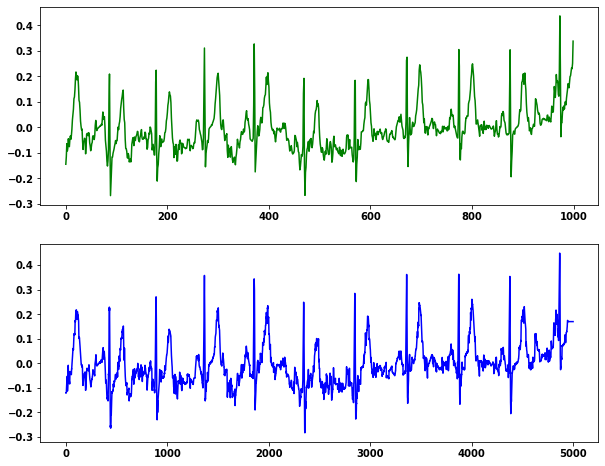

In [ ]:
signal = X_test[0]
signal_hr = X_test_hr[0]
fig, axs = plt.subplots(2, 1, figsize = (10, 8))
axs[0].plot(signal[0, :], "g")
axs[1].plot(signal_hr[0, :], "b")

(12, 1000)


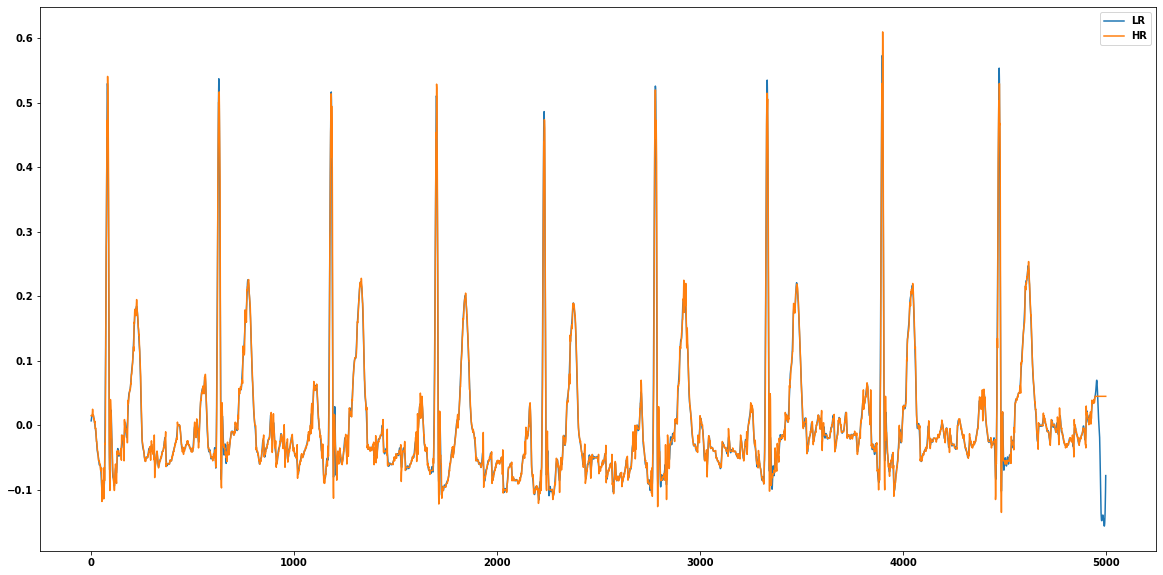

In [ ]:
from scipy import interpolate


plt.figure(figsize = (20, 10))

idx = 100
signal = X_test[idx]
signal_hr = X_test_hr[idx]
ch = 0
signal_ch = signal[ch]
signal_hr_ch = signal_hr[ch]


print(signal.shape)
fs_lr = 100
fs_hr = 500
t_low_res = np.arange(0, 10, 1/fs_lr)
t_high_res = np.arange(0, 10, 1/fs_hr)  # 500 Hz sampling rate

f_interp = interpolate.interp1d(t_low_res, signal_ch, kind="cubic", fill_value="extrapolate")
signal_up_ch = f_interp(t_high_res)

plt.plot(signal_up_ch, label = "LR")
plt.plot(signal_hr_ch, label = "HR")
plt.legend()

In [ ]:
y_train.shape, y_train_sub.shape

((19601,), (19601,))

In [ ]:
X_test.shape, X_test_hr.shape

((2198, 12, 1000), (2198, 12, 5000))

In [ ]:
temp = []
idx_to_remove = []
for i, elem in enumerate(y_train):
    print(i+1, "/", len(list(y_train)), end="\r")
    if len(elem)>0:
        temp.append(elem[0])
    else:
        idx_to_remove.append(i)

X_train = X_train[~np.isin(np.arange(X_train.shape[0]), idx_to_remove)]
X_train_hr = X_train_hr[~np.isin(np.arange(X_train_hr.shape[0]), idx_to_remove)]
y_train_sub = y_train_sub[~np.isin(np.arange(y_train_sub.size), idx_to_remove)]
y_train = np.array(temp)

In [ ]:
y_train_sub[:5]

ecg_id
1    [NORM]
2    [NORM]
3    [NORM]
4    [NORM]
5    [NORM]
Name: diagnostic_subclass, dtype: object

In [ ]:
y_train_sub = [y[0] for y in y_train_sub]
y_train_sub[:5]

['NORM', 'NORM', 'NORM', 'NORM', 'NORM']

In [ ]:
temp = []
idx_to_remove = []
for i, elem in enumerate(y_test):
    print(i+1, "/", len(list(y_test)), end="\r")
    if len(elem)>0:
        temp.append(elem[0])
    else:
        idx_to_remove.append(i)

X_test = X_test[~np.isin(np.arange(X_test.shape[0]), idx_to_remove)]
X_test_hr = X_test_hr[~np.isin(np.arange(X_test_hr.shape[0]), idx_to_remove)]
y_test_sub = y_test_sub[~np.isin(np.arange(y_test_sub.size), idx_to_remove)]
y_test = np.array(temp)

In [ ]:
y_test_sub

ecg_id
9         [NORM]
38        [NORM]
40        [NORM]
57        [NORM]
59        [NORM]
          ...   
21809     [NORM]
21812    [CRBBB]
21818     [NORM]
21819    [IRBBB]
21826      [IMI]
Name: diagnostic_subclass, Length: 2158, dtype: object

In [ ]:
y_test_sub = [y[0] for y in y_test_sub]
y_test_sub[:5]

['NORM', 'NORM', 'NORM', 'NORM', 'NORM']

In [ ]:
len(idx_to_remove)

40

In [ ]:
y_train_uq = np.unique(y_train)
y_train_uq

array(['CD', 'HYP', 'MI', 'NORM', 'STTC'], dtype='<U4')

In [ ]:
map_superclass = {}
for i, uq in enumerate(y_train_uq):
    map_superclass[int(i)] = uq
    y_train[y_train == uq] = int(i)

In [ ]:
y_train[:5]

array(['3', '3', '3', '3', '3'], dtype='<U4')

In [ ]:
map_superclass

{0: 'CD', 1: 'HYP', 2: 'MI', 3: 'NORM', 4: 'STTC'}

In [ ]:
y_train_sub = np.array(y_train_sub)
y_test_sub = np.array(y_test_sub)
y_train_sub_uq = np.unique(y_train_sub)
y_train_sub_uq

array(['AMI', 'CLBBB', 'CRBBB', 'ILBBB', 'IMI', 'IRBBB', 'ISCA', 'ISCI',
       'ISC_', 'IVCD', 'LAFB/LPFB', 'LAO/LAE', 'LMI', 'LVH', 'NORM',
       'NST_', 'PMI', 'RAO/RAE', 'RVH', 'SEHYP', 'STTC', 'WPW', '_AVB'],
      dtype='<U9')

In [ ]:
map_subclass = {}
for i, uq in enumerate(y_train_sub_uq):
    map_subclass[int(i)] = uq
    y_train_sub[y_train_sub == uq] = int(i)

In [ ]:
for i, uq in enumerate(y_train_sub_uq):
    map_subclass[int(i)] = uq
    y_test_sub[y_test_sub == uq] = int(i)

In [ ]:
map_subclass, map_superclass

({0: 'AMI',
  1: 'CLBBB',
  2: 'CRBBB',
  3: 'ILBBB',
  4: 'IMI',
  5: 'IRBBB',
  6: 'ISCA',
  7: 'ISCI',
  8: 'ISC_',
  9: 'IVCD',
  10: 'LAFB/LPFB',
  11: 'LAO/LAE',
  12: 'LMI',
  13: 'LVH',
  14: 'NORM',
  15: 'NST_',
  16: 'PMI',
  17: 'RAO/RAE',
  18: 'RVH',
  19: 'SEHYP',
  20: 'STTC',
  21: 'WPW',
  22: '_AVB'},
 {0: 'CD', 1: 'HYP', 2: 'MI', 3: 'NORM', 4: 'STTC'})

In [ ]:
y_train = np.array(y_train, dtype = float)
y_train = torch.from_numpy(y_train).to(device)
y_train_sub = np.array(y_train_sub, dtype = float)
y_train_sub = torch.from_numpy(y_train_sub).to(device)
y_train.shape, y_train_sub.shape

(torch.Size([19230]), torch.Size([19230]))

In [ ]:
y_train[:5], y_train_sub[:5]

(tensor([3., 3., 3., 3., 3.], device='cuda:0', dtype=torch.float64),
 tensor([14., 14., 14., 14., 14.], device='cuda:0', dtype=torch.float64))

In [ ]:
map_superclass = {0: 'CD', 1: 'HYP', 2: 'MI', 3: 'NORM', 4: 'STTC'}

In [ ]:
for idx, label in map_superclass.items():
    y_test[y_test==label] = idx
y_test = np.array(y_test, dtype = float)
y_test = torch.from_numpy(y_test).to(device)
y_test.shape

torch.Size([2158])

In [ ]:
y_test_sub = np.array(y_test_sub, dtype = float)
y_test_sub = torch.from_numpy(y_test_sub).to(device)
y_test.shape, y_test_sub.shape

(torch.Size([2158]), torch.Size([2158]))

In [ ]:
gc.collect()
torch.cuda.empty_cache()

X_train = torch.from_numpy(X_train).to(device)
X_train_hr = torch.from_numpy(X_train_hr).to(device)
X_test = torch.from_numpy(X_test).to(device)
X_test_hr = torch.from_numpy(X_test_hr).to(device)
X_train.shape

torch.Size([19230, 12, 1000])

In [ ]:
ch = 1
data = X_test[0, ch, :]
data_hr = X_test_hr[0, ch, :]
data = data.cpu().numpy()
data_hr = X_test_hr[0, ch, :]
data_hr = data_hr.cpu().numpy()
fs_lr = 50
fs_hr = 500

In [ ]:
def resample_signal(data, fs=50, nchs = 12, fin = 100):

    data = data.cpu()

    secs = data.shape[-1]/(fin)
    size = int(fs*secs)

    resampled_data = []
    for ch in range(nchs):
        temp = scipy.signal.resample(x=data[ch, :], num=size)
        resampled_data.append(torch.from_numpy(temp))

    resampled_data = torch.stack(resampled_data)

    return resampled_data

In [ ]:
X_train.shape

torch.Size([19230, 12, 1000])

In [ ]:
temp = []
for i, signal in enumerate(X_train):
    print(i, end = "\r")
    signal = resample_signal(signal)
    temp.append(myfilter(0.5, signal.cpu(),  powerline = None, fs = fs_lr))

temp = torch.stack(temp)
temp = torch.unsqueeze(temp, dim = 1)
temp = temp.type(torch.FloatTensor).to(device)
X_train = temp
print("")

gc.collect()
torch.cuda.empty_cache()
temp = torch.zeros_like(X_train_hr.cpu())
for i, signal in enumerate(X_train_hr):
    print(i, end = "\r")
    temp[i, :, :] = myfilter_hr(0.5, 150, signal.cpu(), powerline = 50, fs = fs_hr)
temp = torch.unsqueeze(temp, dim = 1)
temp = temp.type(torch.FloatTensor).to(device)
X_train_hr = temp
print("")

gc.collect()
torch.cuda.empty_cache()
temp = []
for i, signal in enumerate(X_test):
    print(i, end = "\r")
    signal = resample_signal(signal) #100 to 50 Hz
    temp.append(myfilter(0.5, signal.cpu(),  powerline = None, fs = fs_lr))

temp = torch.stack(temp)
temp = torch.unsqueeze(temp, dim = 1)
temp = temp.type(torch.FloatTensor).to(device)
X_test = temp
print("")

gc.collect()
torch.cuda.empty_cache()
temp = torch.zeros_like(X_test_hr.cpu())
for i, signal in enumerate(X_test_hr):
    print(i, end = "\r")
    temp[i, :, :] = myfilter_hr(0.5, 150, signal.cpu(), powerline = 50, fs = fs_hr)

temp = torch.unsqueeze(temp, dim = 1)
temp = temp.type(torch.FloatTensor).to(device)
X_test_hr = temp
print("")

19229
19229
2157
2157


In [ ]:
map_superclass_rev

{'CD': 0, 'HYP': 1, 'MI': 2, 'NORM': 3, 'STTC': 4}

In [ ]:
label = "MI"
uq = map_superclass_rev[label]
idxs = np.argwhere(y_test.cpu().numpy() == int(uq)).flatten()
test_lr = torch.squeeze(X_test[idxs], dim = 1)
test_hr = torch.squeeze(X_test_hr[idxs], dim = 1)
torch.save(test_lr, "test_lr_MI_50.pt")
torch.save(test_hr, "test_hr_MI.pt")

In [ ]:
#y_train = np.array(y_train, dtype = int)
#y_train = torch.from_numpy(y_train).float().to(device)
y_train

tensor([3., 3., 3.,  ..., 4., 3., 3.], device='cuda:0', dtype=torch.float64)

In [ ]:
#y_train_sub = np.array(y_train_sub, dtype = int)
#y_train_sub = torch.from_numpy(y_train_sub).float().to(device)
y_train_sub

tensor([14., 14., 14.,  ...,  6., 14., 14.], device='cuda:0',
       dtype=torch.float64)

In [ ]:
X_train.shape, y_train.shape, y_train_sub.shape

(torch.Size([19230, 1, 12, 500]), torch.Size([19230]), torch.Size([19230]))

In [ ]:
X_test.shape, y_test.shape, y_test.shape

(torch.Size([2158, 1, 12, 500]), torch.Size([2158]), torch.Size([2158]))

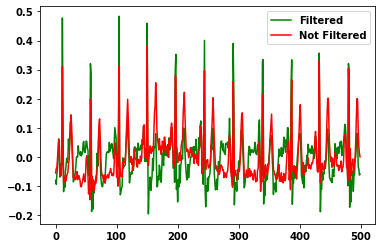

In [ ]:
y = [elem for elem in list(X_train[0, 0, 0, :].cpu())]
sig = torch.from_numpy(X[0])
sig = resample_signal(sig, fs = 50)
y_or = [elem for elem in list(sig[ch, :])]
n = len(y)
x = np.arange(0, n, 1)
%matplotlib inline
plt.plot(x, y, "g", label = "Filtered")
plt.plot(x, y_or, "r", label = "Not Filtered")
plt.legend()

In [ ]:
from scipy import interpolate

plt.figure(figsize = (20, 10))
idx = 200
signal = X_test[idx].cpu()
signal_hr = X_test_hr[idx].cpu()
ch = 0
signal_ch = signal[0, ch]
signal_hr_ch = signal_hr[0, ch]

fs_lr = 100
fs_hr = 500
t_low_res = np.arange(0, 10, 1/fs_lr)
t_high_res = np.arange(0, 10, 1/fs_hr)  # 500 Hz sampling rate

print(signal_ch.shape, t_low_res.shape)
f_interp = interpolate.interp1d(t_low_res, signal_ch, kind="cubic", fill_value="extrapolate")
signal_up_ch = f_interp(t_high_res)

plt.plot(signal_up_ch, label = "LR")
plt.plot(signal_hr_ch, label = "HR")
plt.legend()

torch.Size([500]) (1000,)


ValueError: x and y arrays must be equal in length along interpolation axis.

<Figure size 1440x720 with 0 Axes>

In [ ]:
plt.figure(figsize = (20, 10))
sig = torch.from_numpy(X[0])
sig = resample_signal(sig, fs = 50, fin = 100)
sig = resample_signal(sig, fs = 500, fin = 50)
sig_hr = X_hr[0]
plt.plot(sig[0, :], label = "lr")
plt.plot(sig_hr[0, :], label = "hr")
plt.plot(sig[0, :] - sig_hr[0, :], label = "diff")
plt.legend()

In [ ]:
uqs = torch.unique(y_train.cpu())
dict_train_data = {}
dict_train_data_hr = {}
dict_test_data = {}
dict_test_data_hr = {}

for uq in uqs:

    print(int(uq), ":", map_superclass[int(uq)])
    idxs = np.argwhere(y_train.cpu().numpy() == int(uq)).flatten()
    dict_train_data[map_superclass[int(uq)]] = torch.squeeze(X_train[idxs], dim = 1)
    dict_train_data_hr[map_superclass[int(uq)]] = torch.squeeze(X_train_hr[idxs], dim = 1)

    idxs = np.argwhere(y_test.cpu().numpy() == int(uq)).flatten()
    dict_test_data[map_superclass[int(uq)]] = torch.squeeze(X_test[idxs], dim = 1)
    dict_test_data_hr[map_superclass[int(uq)]] = torch.squeeze(X_test_hr[idxs], dim = 1)

0 : CD
1 : HYP
2 : MI
3 : NORM
4 : STTC


In [ ]:
uqs = torch.unique(y_train_sub.cpu())
dict_train_data_sub = {}
dict_train_data_sub_hr = {}
dict_test_data_sub = {}
dict_test_data_sub_hr = {}

for uq in uqs:

    print(int(uq), ":", map_subclass[int(uq)])
    idxs = np.argwhere(y_train_sub.cpu().numpy() == int(uq)).flatten()
    dict_train_data_sub[map_subclass[int(uq)]] = torch.squeeze(X_train[idxs], dim = 1).cpu()
    dict_train_data_sub_hr[map_subclass[int(uq)]] = torch.squeeze(X_train_hr[idxs], dim = 1).cpu()

    idxs = np.argwhere(y_test_sub.cpu().numpy() == int(uq)).flatten()
    dict_test_data_sub[map_subclass[int(uq)]] = torch.squeeze(X_test[idxs], dim = 1).cpu()
    dict_test_data_sub_hr[map_subclass[int(uq)]] = torch.squeeze(X_test_hr[idxs], dim = 1).cpu()

0 : AMI
1 : CLBBB
2 : CRBBB
3 : ILBBB
4 : IMI
5 : IRBBB
6 : ISCA
7 : ISCI
8 : ISC_
9 : IVCD
10 : LAFB/LPFB
11 : LAO/LAE
12 : LMI
13 : LVH
14 : NORM
15 : NST_
16 : PMI
17 : RAO/RAE
18 : RVH
19 : SEHYP
20 : STTC
21 : WPW
22 : _AVB


In [ ]:
for key, tensor in dict_train_data.items():
    print(key, ":", tensor.shape)

CD : torch.Size([2080, 12, 500])
HYP : torch.Size([1186, 12, 500])
MI : torch.Size([4880, 12, 500])
NORM : torch.Size([8551, 12, 500])
STTC : torch.Size([2533, 12, 500])


In [ ]:
map_subclass

{0: 'AMI',
 1: 'CLBBB',
 2: 'CRBBB',
 3: 'ILBBB',
 4: 'IMI',
 5: 'IRBBB',
 6: 'ISCA',
 7: 'ISCI',
 8: 'ISC_',
 9: 'IVCD',
 10: 'LAFB/LPFB',
 11: 'LAO/LAE',
 12: 'LMI',
 13: 'LVH',
 14: 'NORM',
 15: 'NST_',
 16: 'PMI',
 17: 'RAO/RAE',
 18: 'RVH',
 19: 'SEHYP',
 20: 'STTC',
 21: 'WPW',
 22: '_AVB'}

In [ ]:
for key, tensor in dict_train_data_sub.items():
    print(key, ":", tensor.shape)

AMI : torch.Size([2234, 12, 500])
CLBBB : torch.Size([450, 12, 500])
CRBBB : torch.Size([224, 12, 500])
ILBBB : torch.Size([26, 12, 500])
IMI : torch.Size([2515, 12, 500])
IRBBB : torch.Size([448, 12, 500])
ISCA : torch.Size([357, 12, 500])
ISCI : torch.Size([154, 12, 500])
ISC_ : torch.Size([160, 12, 500])
IVCD : torch.Size([137, 12, 500])
LAFB/LPFB : torch.Size([635, 12, 500])
LAO/LAE : torch.Size([48, 12, 500])
LMI : torch.Size([119, 12, 500])
LVH : torch.Size([1099, 12, 500])
NORM : torch.Size([8551, 12, 500])
NST_ : torch.Size([433, 12, 500])
PMI : torch.Size([12, 12, 500])
RAO/RAE : torch.Size([18, 12, 500])
RVH : torch.Size([13, 12, 500])
SEHYP : torch.Size([8, 12, 500])
STTC : torch.Size([1429, 12, 500])
WPW : torch.Size([65, 12, 500])
_AVB : torch.Size([95, 12, 500])


In [ ]:
fs = 50
windows_test, windows_test_sub = split_windows(X_test, y_test_sub, width = fs*5, stride = fs*5)
fs = 500
windows_test_hr, windows_test_sub = split_windows(X_test_hr, y_test_sub, width = fs*5, stride = fs*5)

pt_data_path = os.getcwd() + os.sep + "pt_data" + os.sep
torch.save(windows_test, pt_data_path+"X_test_unf.pt")
torch.save(windows_test_hr, pt_data_path+"X_test_unf_hr.pt")

In [ ]:
windows_test_hr.shape, X_test_hr.shape

(torch.Size([4316, 1, 12, 2500]), torch.Size([2158, 1, 12, 5000]))

In [ ]:
fs = 50
windows_test, windows_test_labels = split_windows(X_test, y_test, width = fs*5, stride = fs*5)
fs = 500
windows_test_hr, windows_test_labels = split_windows(X_test_hr, y_test, width = fs*5, stride = fs*5)

In [ ]:
fs = 50
windows_train, windows_train_sub = split_windows(X_train, y_train_sub, width = fs*5, stride = fs*5)
fs = 500
windows_train_hr, windows_train_sub = split_windows(X_train_hr, y_train_sub, width = fs*5, stride = fs*5)

In [ ]:
windows_train_hr.shape, X_train_hr.shape

(torch.Size([38460, 1, 12, 2500]), torch.Size([19230, 1, 12, 5000]))

In [ ]:
fs = 50
windows_train, windows_train_labels = split_windows(X_train, y_train, width = fs*5, stride = fs*5)
fs = 500
windows_train_hr, windows_train_labels = split_windows(X_train_hr, y_train, width = fs*5, stride = fs*5)

In [ ]:
pt_data_path = os.getcwd() + os.sep + "pt_data" + os.sep + "subclasses"

filename = pt_data_path+ os.sep + "y_test_sup.pt"
torch.save(windows_test_labels, filename)
filename = pt_data_path+ os.sep + "y_test_sub.pt"
torch.save(windows_test_sub, filename)
filename = pt_data_path+ os.sep + "y_train_sup.pt"
torch.save(windows_train_labels, filename)
filename = pt_data_path+ os.sep + "y_train_sub.pt"
torch.save(windows_train_sub, filename)

In [ ]:
dict_windows_train = {}
dict_windows_train_hr = {}
dict_windows_test = {}
dict_windows_test_hr = {}

for i, (label, tensor) in enumerate(dict_train_data.items()):

    print(label)
    n = len(tensor)
    labels = [i]*n
    labels = torch.FloatTensor(labels)
    fs = 50
    windows_data, windows_labels = split_windows(tensor, labels, width = fs*5, stride = fs*5)
    #windows_data = torch.unsqueeze(tensor, dim = 1)
    windows_labels = labels
    dict_windows_train[label] = windows_data.to(device)

    tensor_hr = dict_train_data_hr[label]
    fs = 500
    windows_data, windows_labels = split_windows(tensor_hr, labels, width = fs*5, stride = fs*5)


    dict_windows_train_hr[label] = windows_data.to(device)

for i, (label, tensor) in enumerate(dict_test_data.items()):

    print(label)
    n = len(tensor)
    labels = [i]*n
    labels = torch.FloatTensor(labels)
    fs = 50
    windows_data, windows_labels = split_windows(tensor, labels, width = fs*5, stride = fs*5)
    #windows_data = torch.unsqueeze(tensor, dim = 1)
    windows_labels = labels
    dict_windows_test[label] = windows_data.to(device)

    tensor_hr = dict_test_data_hr[label]
    fs = 500
    windows_data, windows_labels = split_windows(tensor_hr, labels, width = fs*5, stride = fs*5)

    dict_windows_test_hr[label] = windows_data.to(device)

CD
HYP
MI
NORM
STTC
CD
HYP
MI
NORM
STTC


In [ ]:
dict_windows_train_hr["MI"].shape

torch.Size([9760, 1, 12, 2500])

In [ ]:
dict_windows_train_sub = {}
dict_windows_train_sub_hr = {}
dict_windows_test_sub = {}
dict_windows_test_sub_hr = {}

gc.collect()
torch.cuda.empty_cache()
for i, (label, tensor) in enumerate(dict_train_data_sub.items()):

    print(label)
    n = len(tensor)
    labels = [i]*n*2
    labels = torch.FloatTensor(labels)
    fs = 50
    windows_data, windows_labels = split_windows(tensor, labels, width = fs*5, stride =  fs*5)
    #windows_data = torch.unsqueeze(tensor, dim = 1)
    windows_labels = labels
    dict_windows_train_sub[label] = windows_data#.to(device)

    fs = 500
    tensor_hr = dict_train_data_sub_hr[label]
    #windows_data = torch.unsqueeze(tensor_hr, dim = 1)
    windows_labels = labels
    windows_data, windows_labels = split_windows(tensor_hr, labels, width = fs*5, stride =  fs*5)
    dict_windows_train_sub_hr[label] = windows_data#.to(device)

for i, (label, tensor) in enumerate(dict_test_data_sub.items()):

    print(label)
    n = len(tensor)
    labels = [i]*n*2
    labels = torch.FloatTensor(labels)
    #windows_data = torch.unsqueeze(tensor, dim = 1)
    windows_labels = labels
    fs = 50
    windows_data, windows_labels = split_windows(tensor, labels, width = fs*5, stride =  fs*5)
    dict_windows_test_sub[label] = windows_data#.to(device)

    tensor_hr = dict_test_data_sub_hr[label]
    #windows_data = torch.unsqueeze(tensor_hr, dim = 1)
    windows_labels = labels
    fs = 500
    windows_data, windows_labels = split_windows(tensor_hr, labels, width = fs*5, stride =  fs*5)
    dict_windows_test_sub_hr[label] = windows_data#.to(device)

AMI
CLBBB
CRBBB
ILBBB
IMI
IRBBB
ISCA
ISCI
ISC_
IVCD
LAFB/LPFB
LAO/LAE
LMI
LVH
NORM
NST_
PMI
RAO/RAE
RVH
SEHYP
STTC
WPW
_AVB
AMI
CLBBB
CRBBB
ILBBB
IMI
IRBBB
ISCA
ISCI
ISC_
IVCD
LAFB/LPFB
LAO/LAE
LMI
LVH
NORM
NST_
PMI
RAO/RAE
RVH
SEHYP
STTC
WPW
_AVB


In [ ]:
from random import choice

n = dict_test_data["NORM"].shape[0]
idxs = np.arange(n)
ch = 0
idx = choice(idxs)
signal = dict_test_data["NORM"][idx]
signal_hr = dict_test_data_hr["NORM"][idx]
fig, axs = plt.subplots(2, 1, figsize = (10, 8))
axs[0].plot(signal[ch, :].cpu(), "g")
axs[1].plot(signal_hr[ch, :].cpu(), "b")

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

491

In [ ]:
for label, tensor in dict_windows_train.items():
    print(label, ":", tensor.shape)

CD : torch.Size([4160, 1, 12, 250])
HYP : torch.Size([2372, 1, 12, 250])
MI : torch.Size([9760, 1, 12, 250])
NORM : torch.Size([17102, 1, 12, 250])
STTC : torch.Size([5066, 1, 12, 250])


In [ ]:
map_superclass_rev = {value: key for key, value in map_superclass.items()}
map_superclass_rev

{'CD': 0, 'HYP': 1, 'MI': 2, 'NORM': 3, 'STTC': 4}

In [ ]:
pt_data_path = os.getcwd() + os.sep + "pt_data"
for label, data in dict_windows_train.items():

    print(label)
    filename = pt_data_path+ os.sep + "train_{}_50.pt".format(label)
    torch.save(data, filename)

for label, data in dict_windows_train_hr.items():

    print(label)
    filename = pt_data_path+ os.sep + "train_{}_hr.pt".format(label)
    torch.save(data, filename)


for label, data in dict_windows_test.items():

    print(label)
    filename = pt_data_path+ os.sep + "test_{}_50.pt".format(label)
    torch.save(data, filename)

for label, data in dict_windows_test_hr.items():

    print(label)
    filename = pt_data_path+ os.sep + "test_{}_hr.pt".format(label)
    torch.save(data, filename)

CD
HYP
MI
NORM
STTC
CD
HYP
MI
NORM
STTC
CD
HYP
MI
NORM
STTC
CD
HYP
MI
NORM
STTC


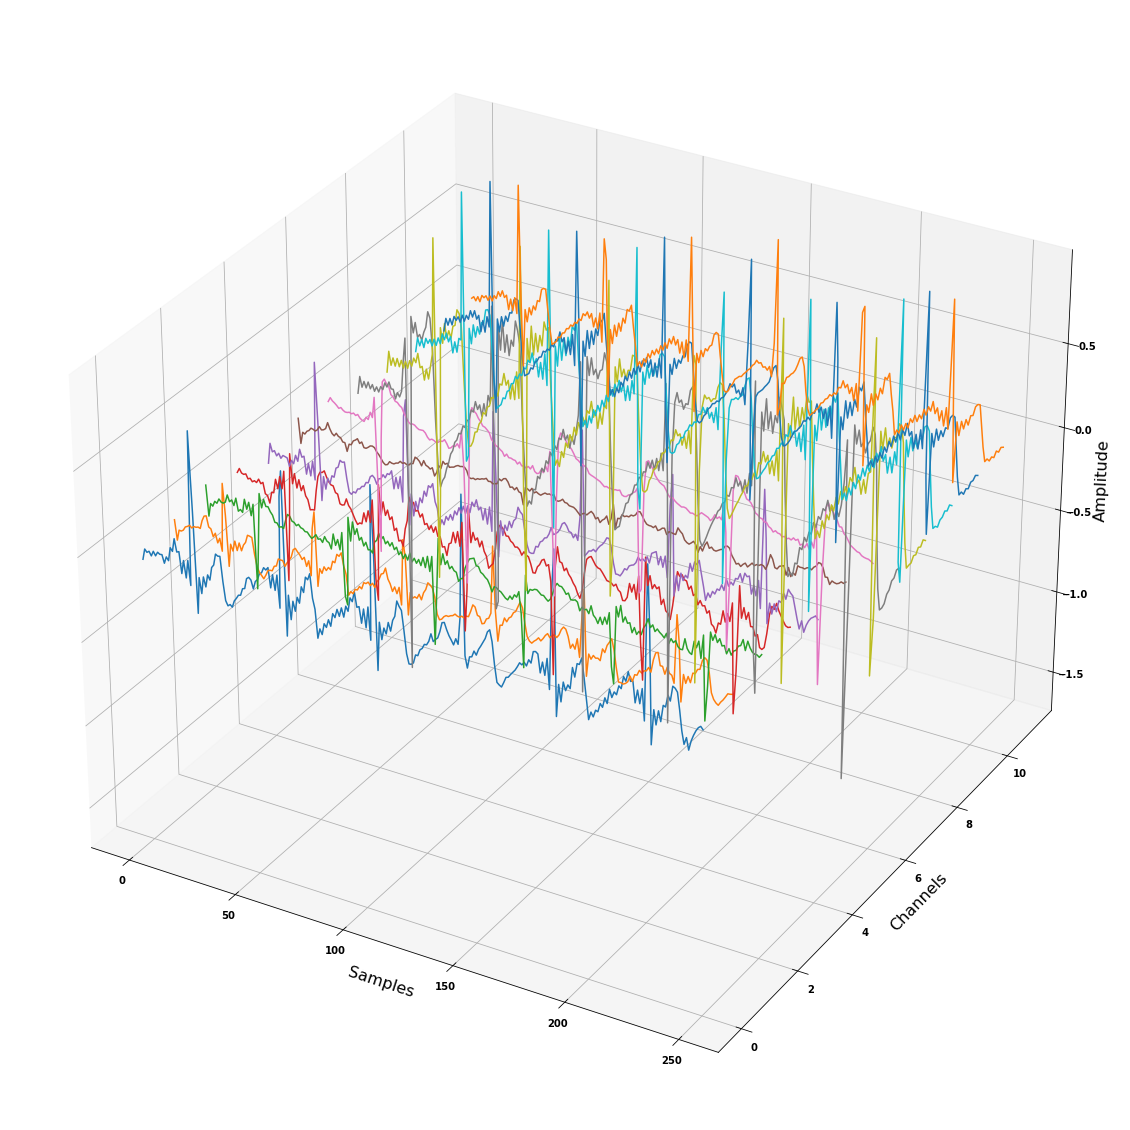

<Figure size 432x288 with 0 Axes>

In [ ]:
#signal 3d visualization

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 3d plot
fig = plt.figure(figsize = (20, 40))
plt.figure(facecolor='white')#background

signal = dict_windows_train["MI"][0, 0].cpu()
n = signal.shape[-1]
nchs = signal.shape[-2]
chs = np.arange(0, nchs, 1)
t = np.arange(0, n, 1)
ax = fig.add_subplot(projection='3d')

for ch in chs:
    signal_ch = signal[ch, :]
    ax.plot(t, signal_ch, ch, zdir = "y")


ax.set_xlabel("Samples", size = 16)
ax.set_ylabel("Channels", size = 16)
ax.set_zlabel("Amplitude", size = 16)
ax.set_facecolor("white")
rcParams['grid.color'] = 'black'
plt.show()

In [ ]:
fig.savefig("lr_3d.png", dpi = 600)

# ADD NOISE TO DATA

In [ ]:
import torch
import os
import neurokit2 as nk

In [ ]:
map_superclass_rev = {'CD': 0, 'HYP': 1, 'MI': 2, 'NORM': 3, 'STTC': 4}

In [ ]:
labels = list(map_superclass_rev.keys())
dict_windows_test_hr = {}
dict_windows_test_lr = {}
dict_windows_train_lr = {}
dict_windows_train_hr = {}
dict_windows_train_lr_n = {}
dict_windows_test_lr_n = {}

path = os.getcwd()+os.sep+"pt_data"+os.sep
for label in labels:

    filename = path + "test_{}_hr.pt".format(label)
    hr_data = torch.load(filename)
    dict_windows_test_hr[label] = hr_data

    filename = path + "test_{}_50.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_test_lr[label] = lr_data

    filename = path + "train_{}_hr.pt".format(label)
    hr_data = torch.load(filename)
    dict_windows_train_hr[label] = hr_data

    filename = path + "train_{}_50.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_train_lr[label] = lr_data

    filename = path + "test_{}_noisy.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_test_lr_n[label] = lr_data

    filename = path + "train_{}_noisy.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_train_lr_n[label] = lr_data

dict_windows_train = dict_windows_train_lr
dict_windows_test = dict_windows_test_lr

In [ ]:
import random

def add_rsp(signal):

    nchs = 12
    duration = 5
    fs = 50

    while True:
        rr_all = np.arange(10, 20, 2)
        rr = random.choice(rr_all)
        #print(rr)
        resp = nk.rsp_simulate(length=fs*duration, sampling_rate = fs, respiratory_rate=rr, method="breathmetrics")

        temp = [torch.from_numpy(resp) for i in range(nchs)]
        resp = torch.from_numpy(np.array(temp))

        if signal.shape == resp.shape:
            break
    noisy_signal = signal.cpu() + resp

    return noisy_signal

In [ ]:
def add_emg(signal):

    nchs = 12
    duration = 5
    fs = 50

    bn = random.choice(np.arange(1, 2))
    emg = nk.emg_simulate(length=fs*duration, sampling_rate = fs, burst_number=bn, burst_duration=1)

    temp = [torch.from_numpy(emg) for i in range(nchs)]
    emg = torch.from_numpy(np.array(temp))
    noisy_signal = signal.cpu() + emg
    return noisy_signal

In [ ]:
def add_eda(signal):

    nchs = 12
    duration = 5
    fs = 50

    edan = random.choice(np.arange(1, 2))
    eda = nk.eda_simulate(duration = 5, length=fs*duration, sampling_rate = fs, scr_number=edan, drift=-0.5)

    temp = [torch.from_numpy(eda) for i in range(nchs)]
    eda = torch.from_numpy(np.array(temp))
    noisy_signal = signal.cpu() + eda
    return noisy_signal

In [ ]:
signal = dict_windows_test_lr[label][0, 0]
signal.shape

torch.Size([12, 250])

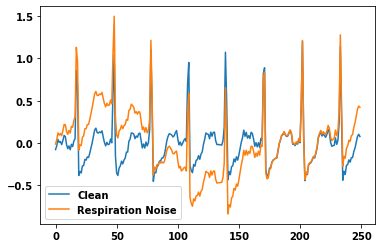

In [ ]:
noisy_signal = add_rsp(signal)
noise_type = "Respiration Noise"
plt.plot(signal[0, :].cpu(), label = "Clean")
plt.plot(noisy_signal[0, :], label = noise_type)
plt.legend()

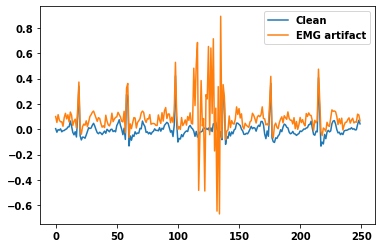

In [ ]:
noisy_signal = add_emg(signal)
noise_type = "EMG artifact"
plt.plot(signal[0, :].cpu(), label = "Clean")
plt.plot(noisy_signal[0, :], label = noise_type)
plt.legend()

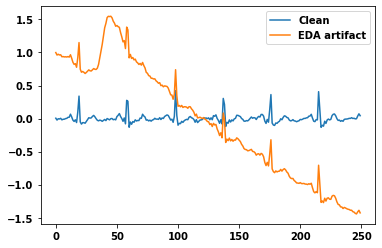

In [ ]:
noisy_signal = add_eda(signal)
noise_type = "EDA artifact"
plt.plot(signal[0, :].cpu(), label = "Clean")
plt.plot(noisy_signal[0, :], label = noise_type)
plt.legend()

(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0')])

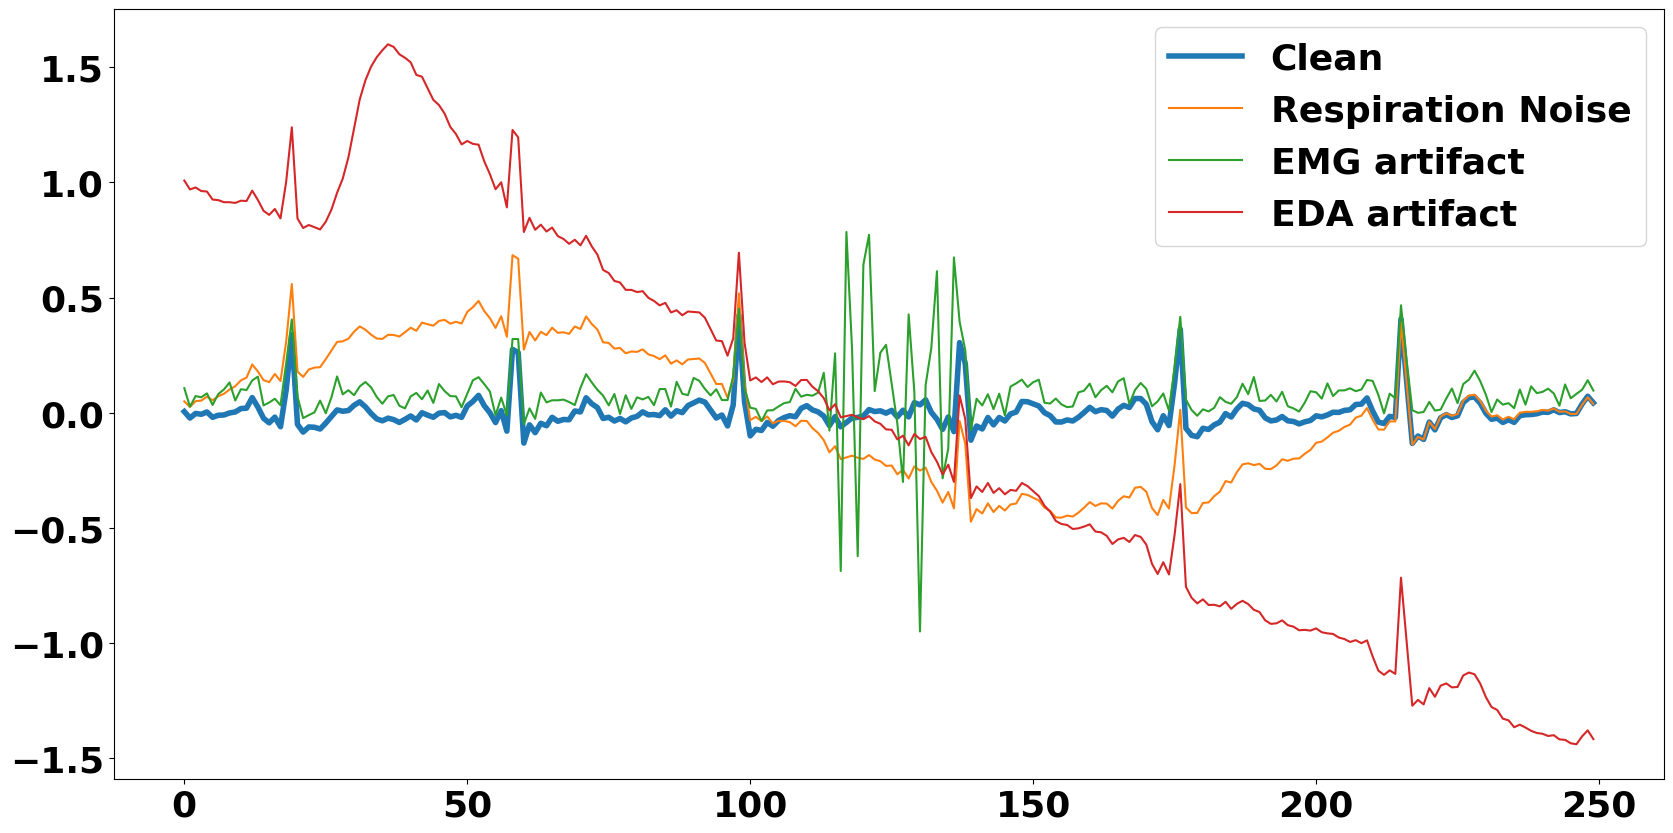

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

noise_functions = {
    "Respiration Noise": add_rsp,
    "EMG artifact": add_emg,
    "EDA artifact": add_eda
}

fig = plt.figure(figsize = (20, 10))
plt.plot(signal[0, :].cpu(), label = "Clean", linewidth = 4)
for noise_type, noise_function in noise_functions.items():

    noisy_signal = noise_function(signal)
    plt.plot(noisy_signal[0, :], label = noise_type)

plt.legend(fontsize="26")
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

In [ ]:
fig.savefig("ecg_artifact_example.png", dpi = 400)

In [16]:
import os
import torch

labels = list(map_superclass_rev.keys())
dict_windows_test_hr = {}
dict_windows_test_lr = {}
dict_windows_train_lr = {}
dict_windows_train_hr = {}
dict_windows_train_lr_n = {}
dict_windows_test_lr_n = {}

path = os.getcwd()+os.sep+"pt_data"+os.sep
for label in labels:

    if label == "All":
      continue
    print(label)
    filename = path + "test_{}_hr.pt".format(label)
    hr_data = torch.load(filename)
    dict_windows_test_hr[label] = hr_data

    filename = path + "test_{}_50.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_test_lr[label] = lr_data

    filename = path + "train_{}_hr.pt".format(label)
    hr_data = torch.load(filename)
    dict_windows_train_hr[label] = hr_data

    filename = path + "train_{}_50.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_train_lr[label] = lr_data

    filename = path + "test_{}_noisy.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_test_lr_n[label] = lr_data

    filename = path + "train_{}_noisy.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_train_lr_n[label] = lr_data

dict_windows_train = dict_windows_train_lr
dict_windows_test = dict_windows_test_lr

CD
HYP
MI
NORM
STTC


In [ ]:
train_noise

{'EMG artifact': 641,
 'Respiration Noise': 594,
 'Normal': 3257,
 'EDA artifact': 570}

In [ ]:
for label in labels:
    signals = dict_windows_test_lr[label]
    noisy_signals = torch.zeros_like(signals)
    test_noise = {}

    n = len(signals)
    for i, signal in enumerate(signals):

        print(i+1, "/", n, end="\r")
        idxs =  [0, 1, 2, 3, 4]
        idx = random.choice(idxs)
        if idx >= 3:
            key = "Normal"
            if key in test_noise.keys():
                test_noise[key] += 1
            else:
                test_noise[key] = 0
            noisy_signals[i, 0, :, :] = signal
            continue
        else:
            keys = list(noise_functions.keys())
            key = keys[idx]
            if key in test_noise.keys():
                test_noise[key] += 1
            else:
                test_noise[key] = 0
            noise_function = noise_functions[key]
            signal = torch.squeeze(signal, dim = 0)
            signal = torch.squeeze(signal, dim = 0)
            noisy_signals[i, 0, :, :] = noise_function(signal)
    print("\n")
    dict_windows_test_lr_n[label] = noisy_signals
    torch.save(noisy_signals, "pt_data/test_{}_noisy.pt".format(label))

490 / 490

244 / 244

1088 / 1088

1926 / 1926

568 / 568



In [ ]:
test_noise

{'Normal': 218,
 'Respiration Noise': 116,
 'EMG artifact': 121,
 'EDA artifact': 109}

In [13]:
device = "cuda:0"
model = torch.load("models/model_2_nodenoising.pt")
model_d = torch.load("models/model_2_denoising_lrhr.pt")
model = model.to(device)
model_d = model_d.to(device)
#model

In [14]:
def resample_single(to_resample, nchs = 12, size = 5*50):

    resampled_data = np.zeros((nchs, size))
    for ch in range(nchs):
        resampled_data[ch, :] = scipy.signal.resample(x=to_resample[ch, :], num=size)

    return resampled_data

In [15]:
from functions import *

In [ ]:
idx = 100#50
signal = dict_windows_test_lr[label][idx, 0]
signal_hr = dict_windows_test_hr[label][idx, 0]
signal.shape, signal_hr.shape

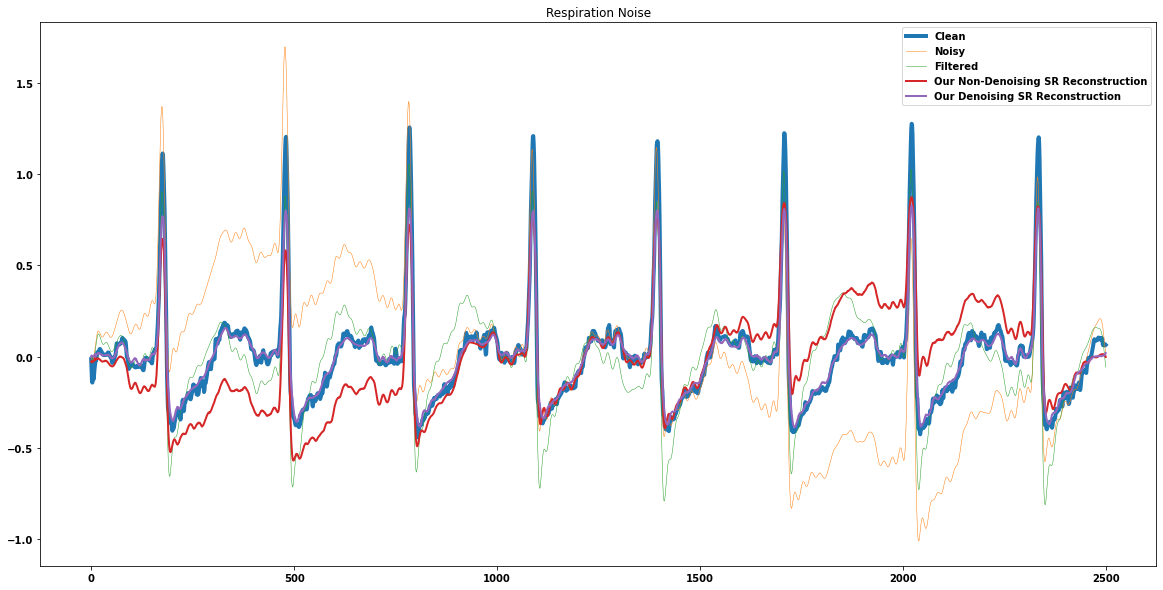

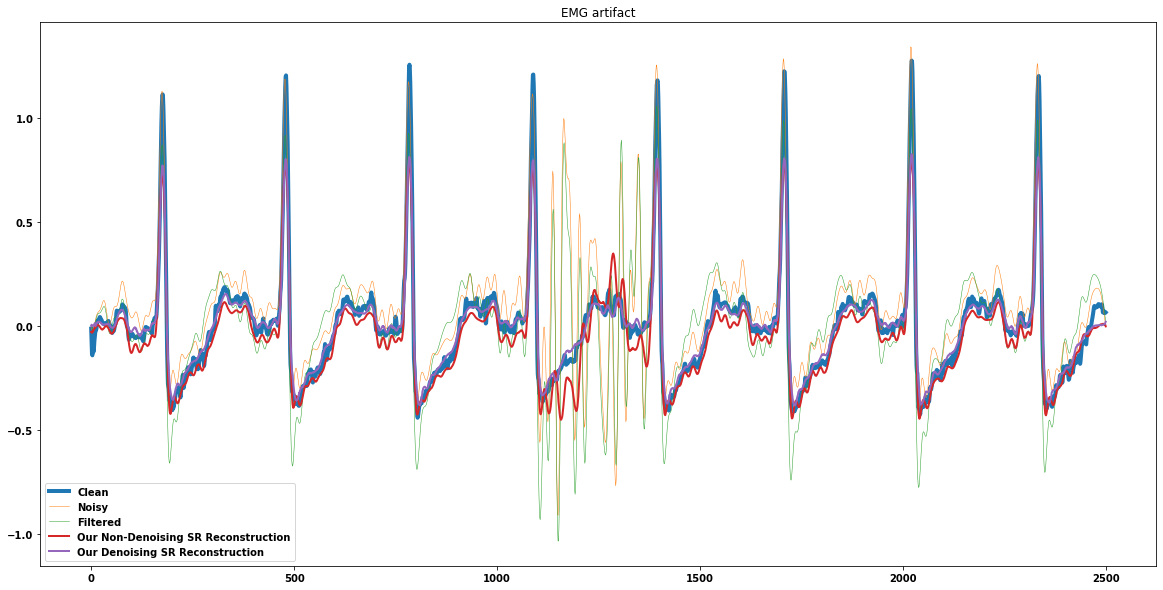

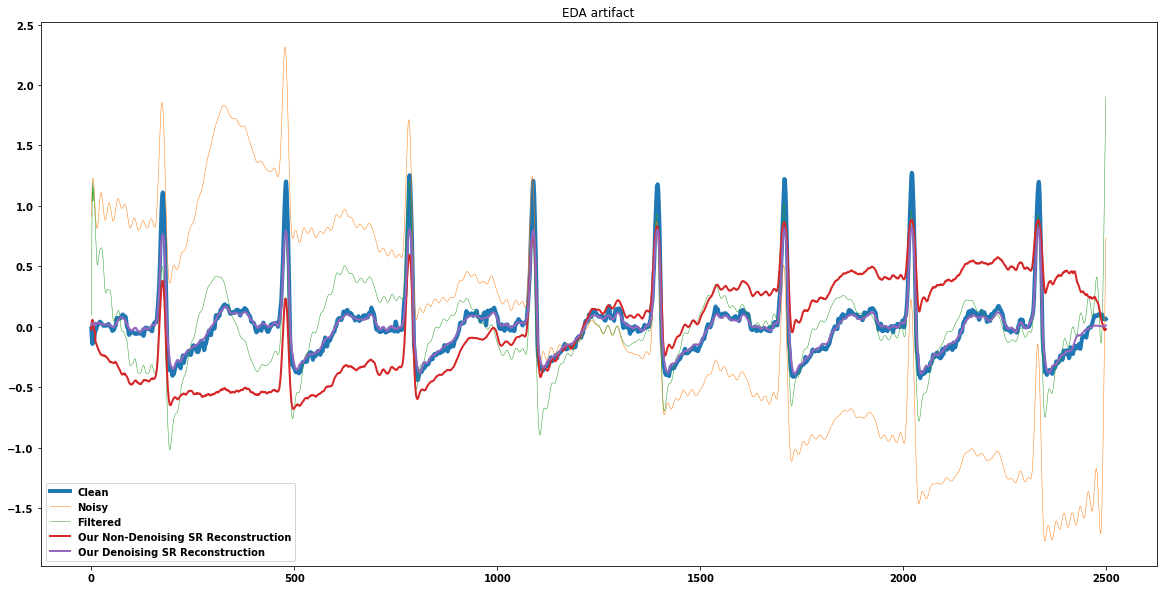

In [ ]:
for noise_type, noise_function in noise_functions.items():

    plt.figure(figsize = (20, 10))
    plt.title(noise_type)

    plt.plot(signal_hr[0, :].cpu(), label = "Clean", linewidth = 4)

    noisy_signal = noise_function(signal)
    noisy_signal_u = resample_single(noisy_signal, 12, 5*500)
    plt.plot(noisy_signal_u[0, :], label = "Noisy", linewidth = 0.5)

    noisy_signal_u = torch.from_numpy(noisy_signal_u)
    filtered = myfilter_hr(0.5, 150, noisy_signal_u, powerline = 50)
    filtered = resample_single(filtered, 12, 5*500)
    plt.plot(filtered[0, :], label = "Filtered", linewidth = 0.5)

    input = torch.unsqueeze(noisy_signal, dim = 0)
    input = torch.unsqueeze(input, dim = 0).float().to(device)
    pred = model([input, None, None, None])
    sr_nd = pred[1].cpu().detach().numpy()
    plt.plot(sr_nd[0, :], label = "Our Non-Denoising SR Reconstruction", linewidth = 2)

    pred_d = model_d([input, None, None, None])
    sr_d = pred_d[1].cpu().detach().numpy()
    plt.plot(sr_d[0, :], label = "Our Denoising SR Reconstruction", linewidth = 2)

    plt.legend()

In [ ]:
labels = list(dict_windows_train_lr.keys())
labels

['CD', 'HYP', 'MI', 'NORM', 'STTC']

In [12]:
import matplotlib.pyplot as plt

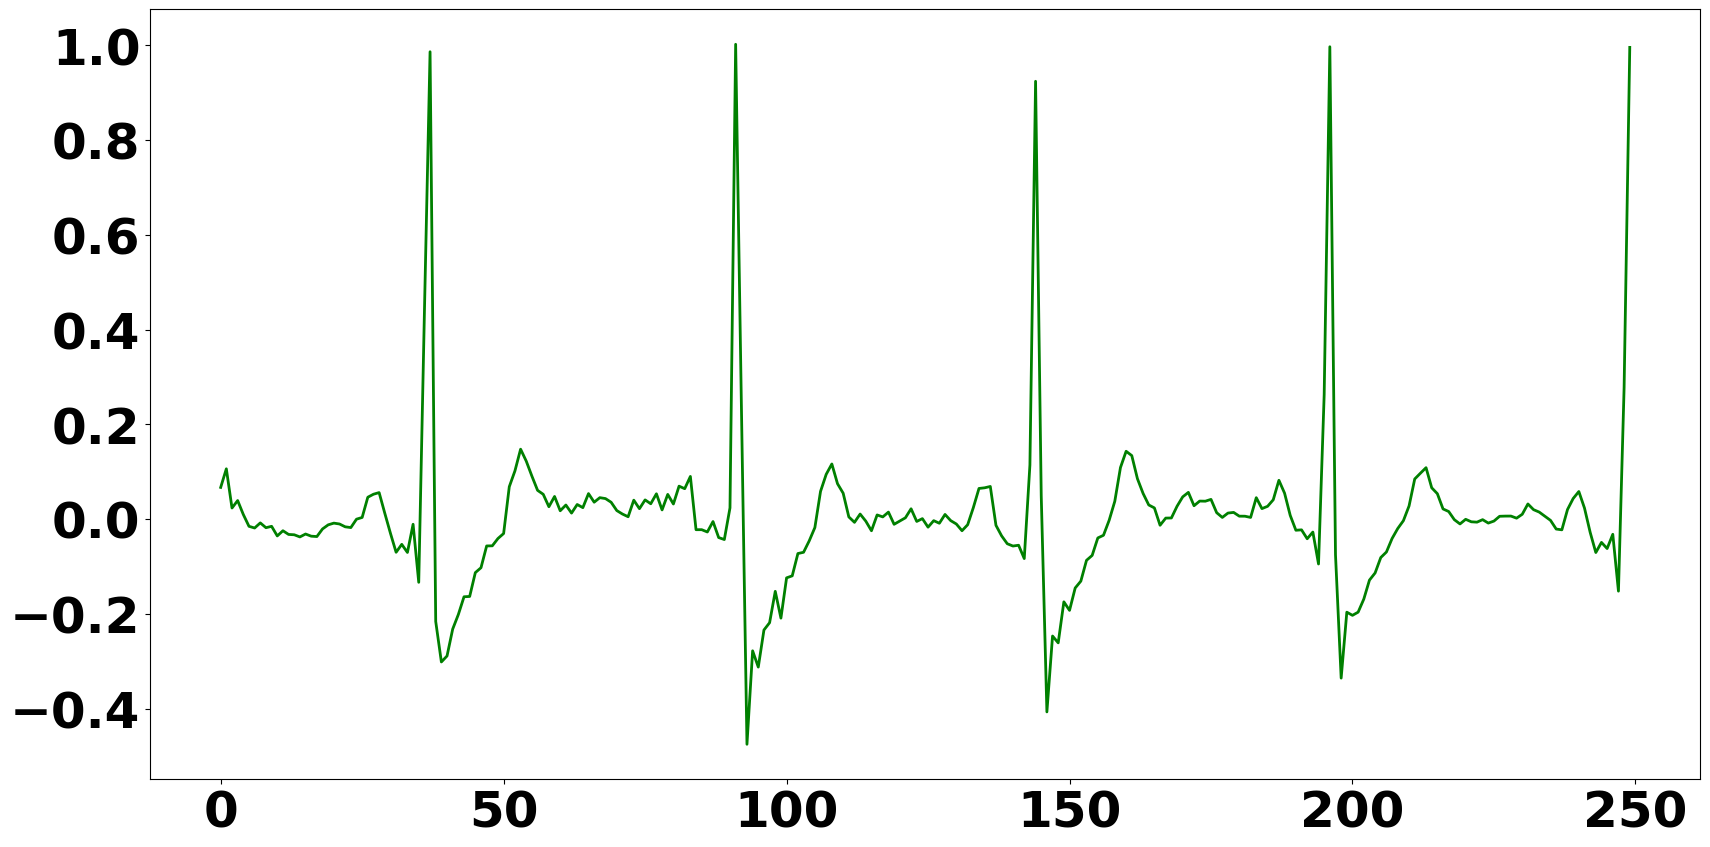

In [ ]:
idx = 100
ch = 0
dpi = 600
label = "MI"
test_lr_n = dict_windows_train_lr_n[label][idx]
fig = plt.figure(figsize = (20, 10))
plt.plot(test_lr_n[0, ch, :].cpu().detach().numpy(), "g", linewidth = 2)
plt.xticks(fontsize=36)
plt.yticks(fontsize=36)
fig.savefig("lr_example_noise.png", dpi=dpi)

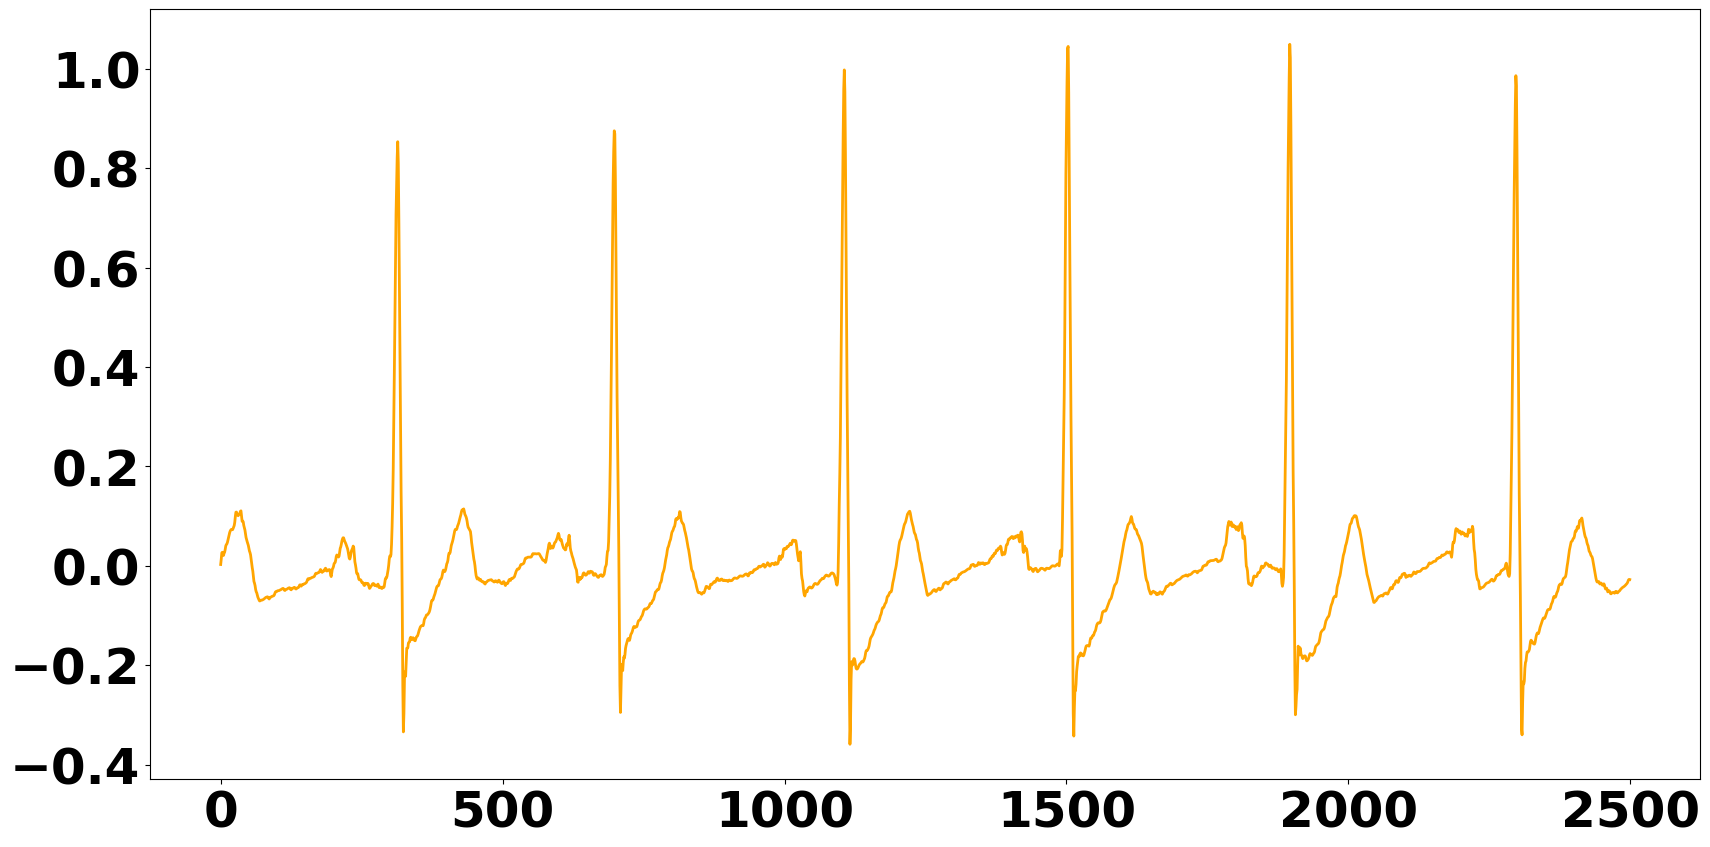

In [ ]:
ch = 0
test_hr = dict_windows_train_hr[label][idx]
fig = plt.figure(figsize = (20, 10))
plt.plot(test_hr[0, ch, :].cpu().detach().numpy(), "orange", linewidth = 2)
plt.xticks(fontsize=36)
plt.yticks(fontsize=36)
fig.savefig("hr_example.png", dpi=dpi)

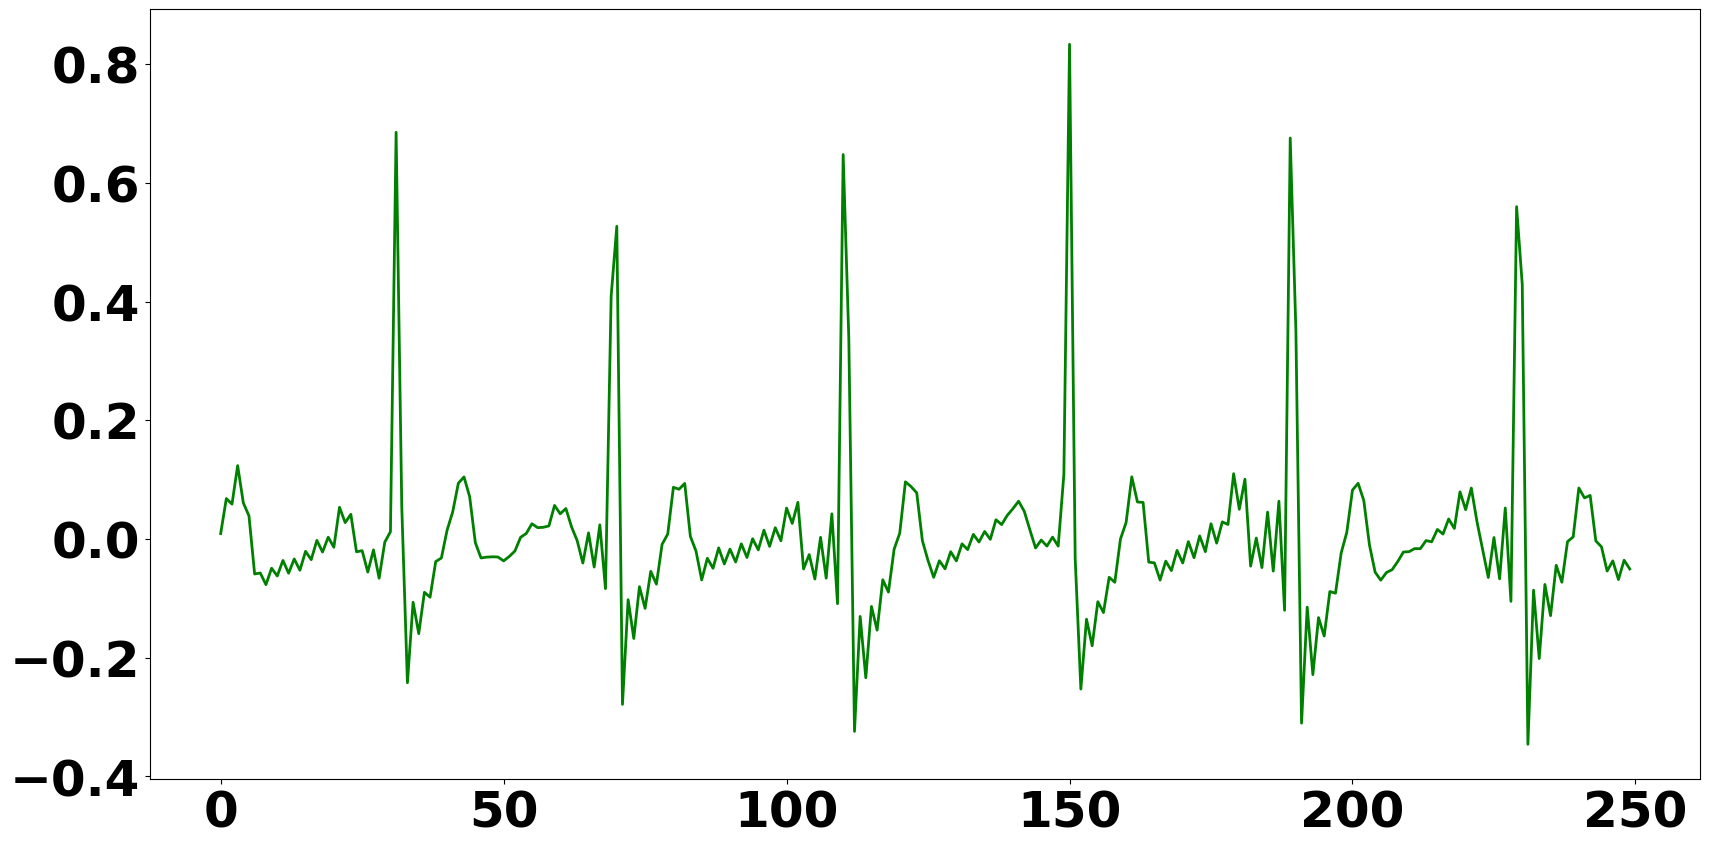

In [ ]:
test_lr = dict_windows_train_lr[label][idx]
fig = plt.figure(figsize = (20, 10))
plt.plot(test_lr[0, ch, :].cpu().detach().numpy(), "g", linewidth = 2)
plt.xticks(fontsize=36)
plt.yticks(fontsize=36)
fig.savefig("lr_example.png", dpi=dpi)

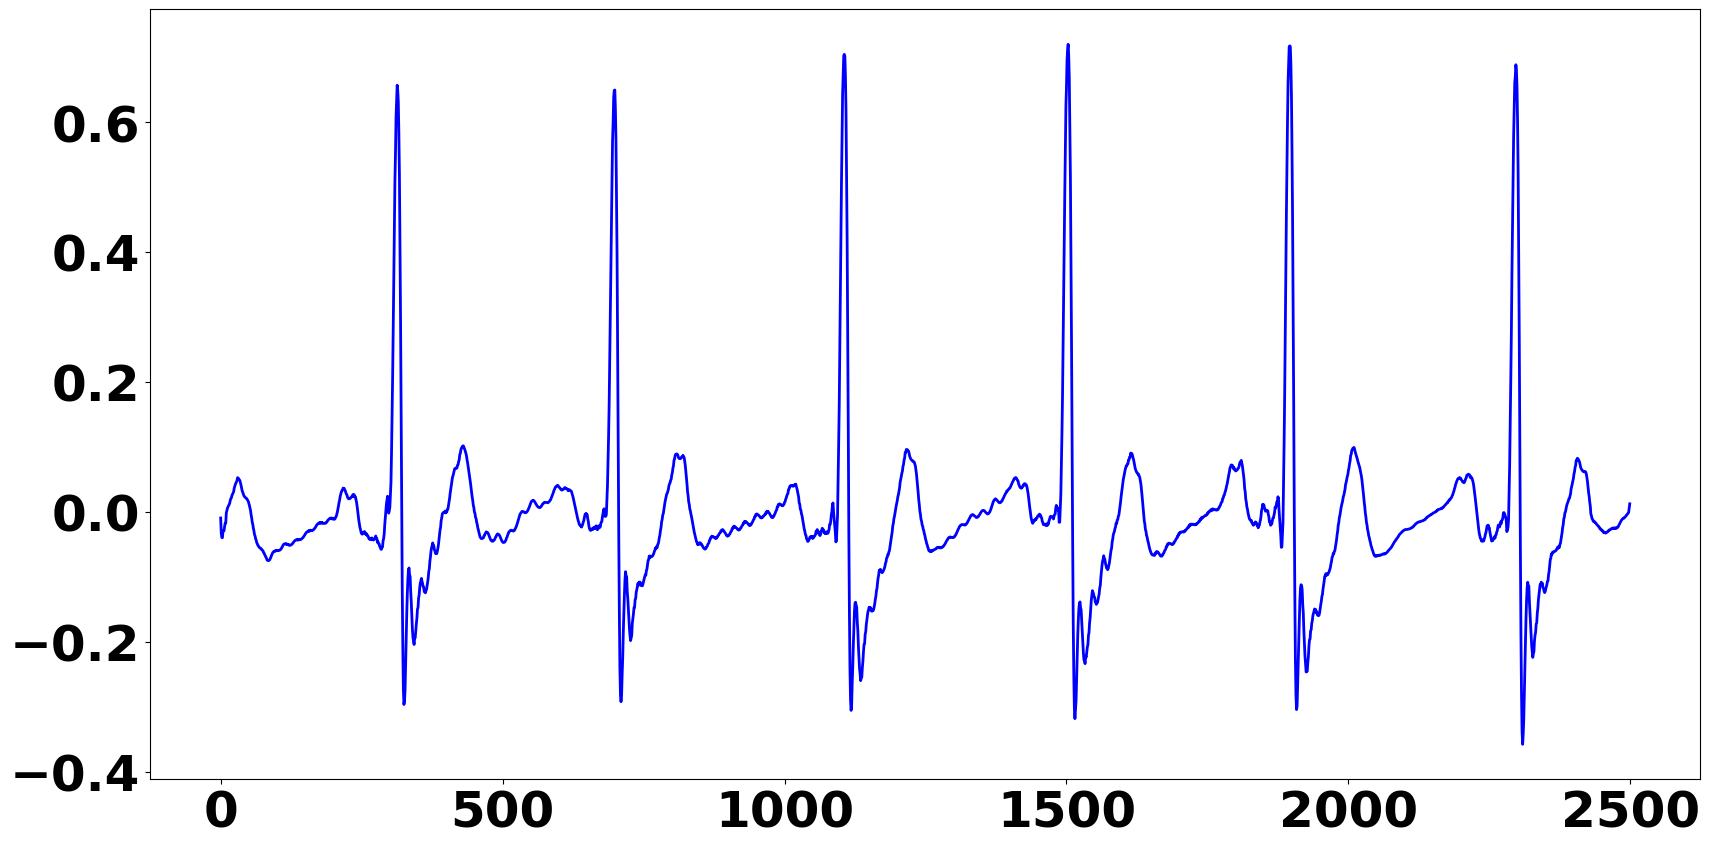

In [ ]:
sr = model_d([test_lr, None, None, None])[1]
fig = plt.figure(figsize = (20, 10))
plt.plot(sr[ch, :].cpu().detach().numpy(), "blue", linewidth = 2)
plt.xticks(fontsize=36)
plt.yticks(fontsize=36)
fig.savefig("sr_example.png", dpi=dpi)

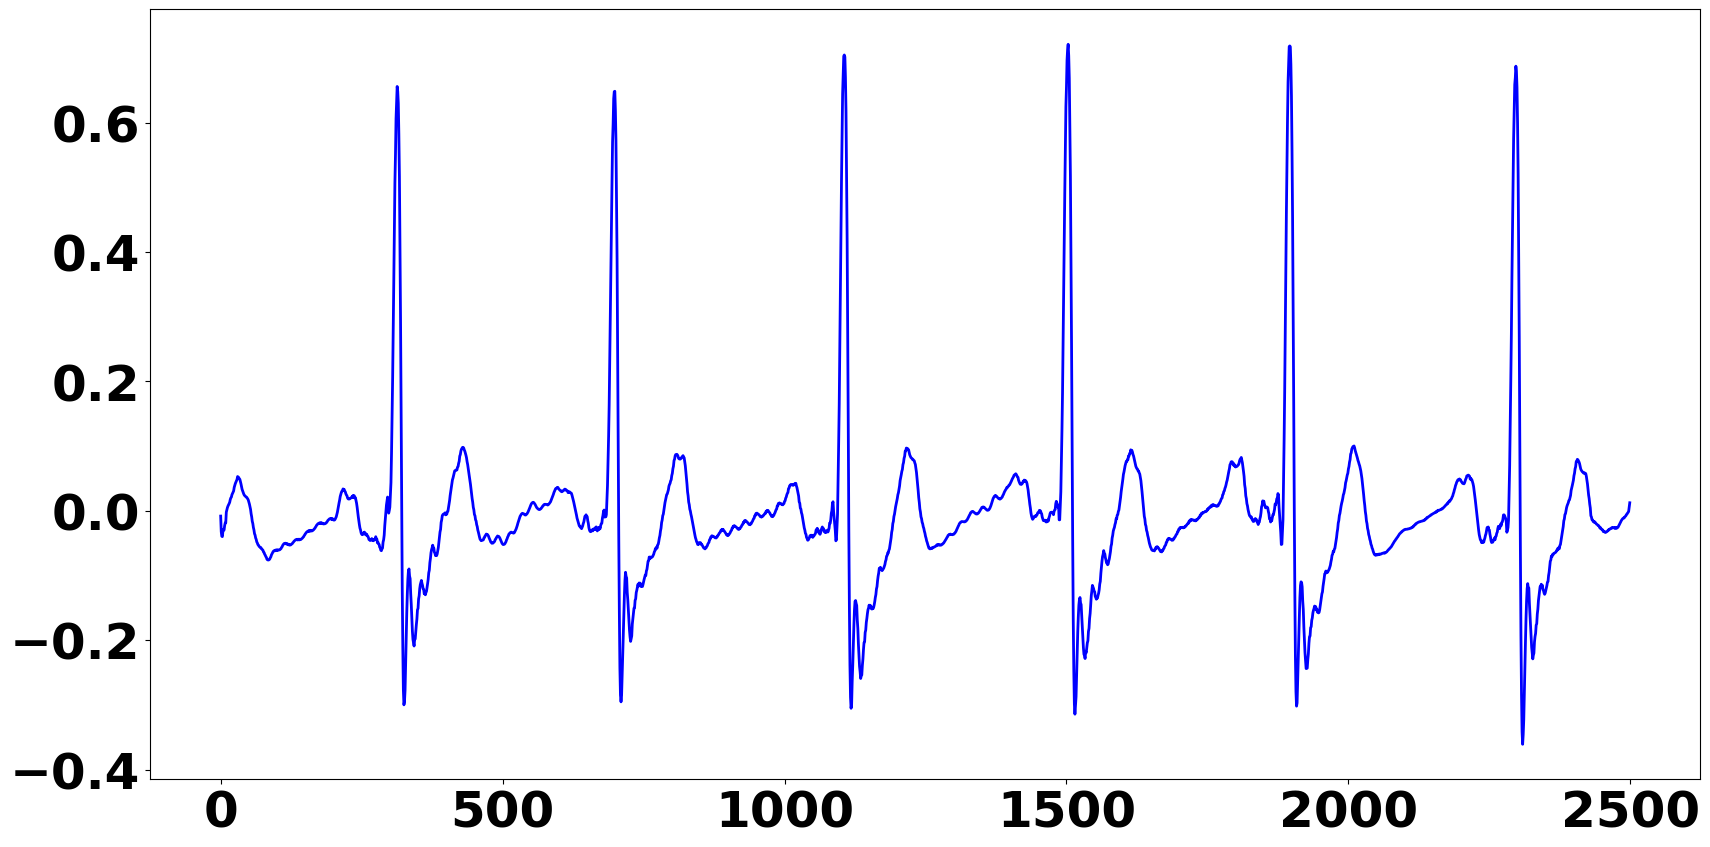

In [ ]:
sr = model_d([test_lr_n, None, None, None])[1]
fig = plt.figure(figsize = (20, 10))
plt.plot(sr[ch, :].cpu().detach().numpy(), "blue", linewidth = 2)
plt.xticks(fontsize=36)
plt.yticks(fontsize=36)
fig.savefig("sr_n_example.png", dpi=dpi)

In [ ]:
(test_lr == test_lr_n).all()

tensor(False, device='cuda:0')

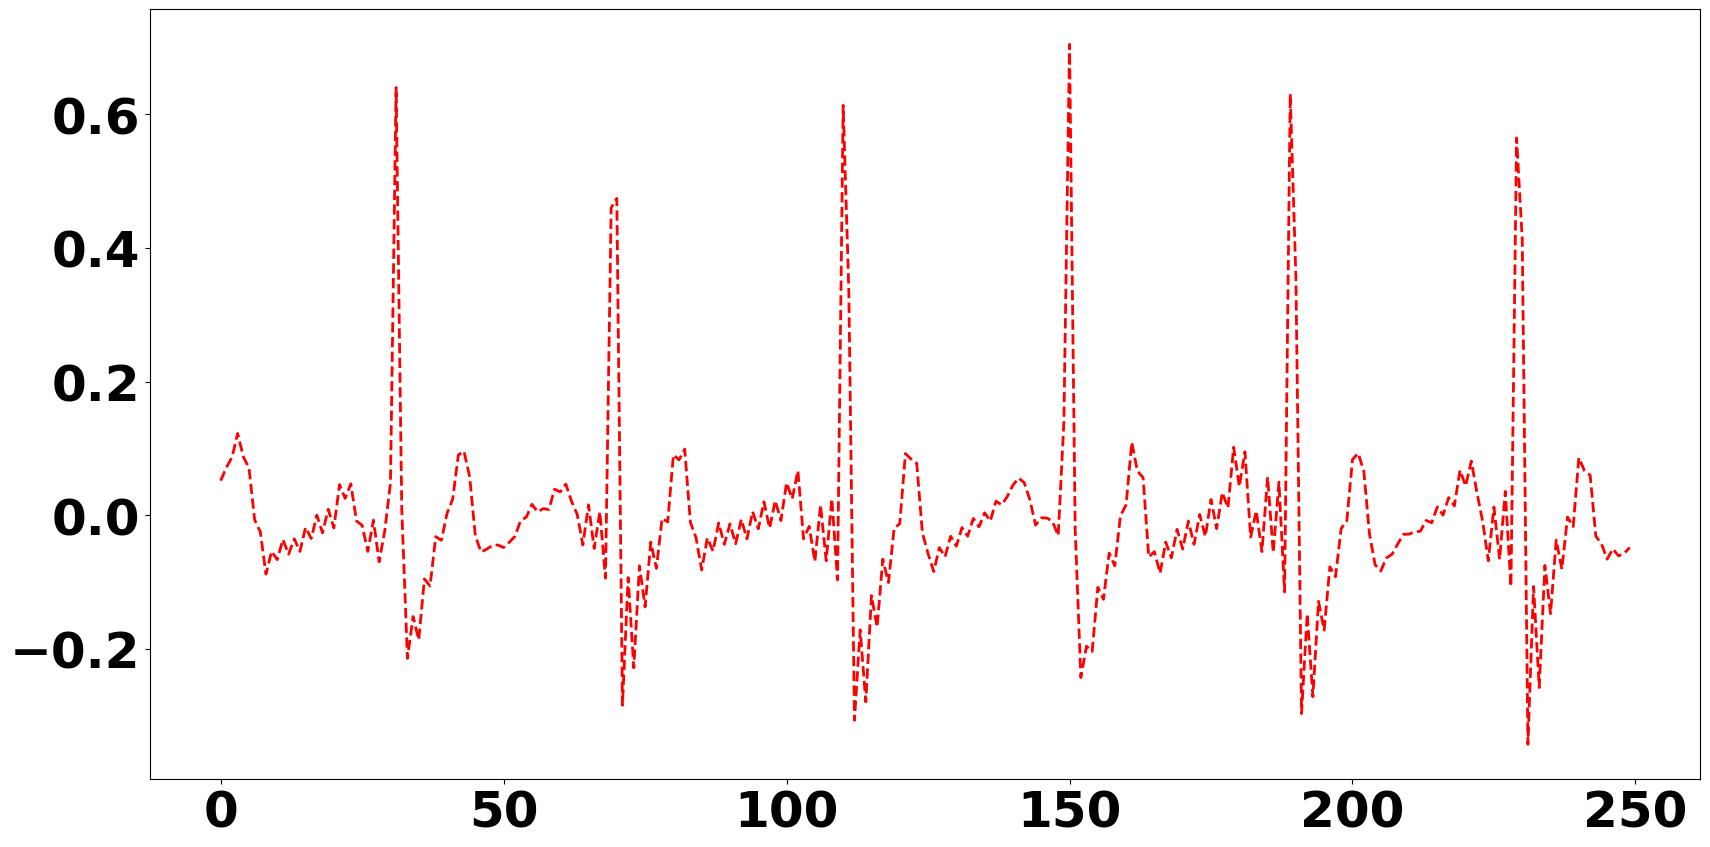

In [ ]:
rec = model_d([test_lr, None, None, None])[0]
fig = plt.figure(figsize = (20, 10))
plt.plot(rec[ch, :].cpu().detach().numpy(), "r--", linewidth = 2)
plt.xticks(fontsize=36)
plt.yticks(fontsize=36)
fig.savefig("rec_example.png", dpi=dpi)

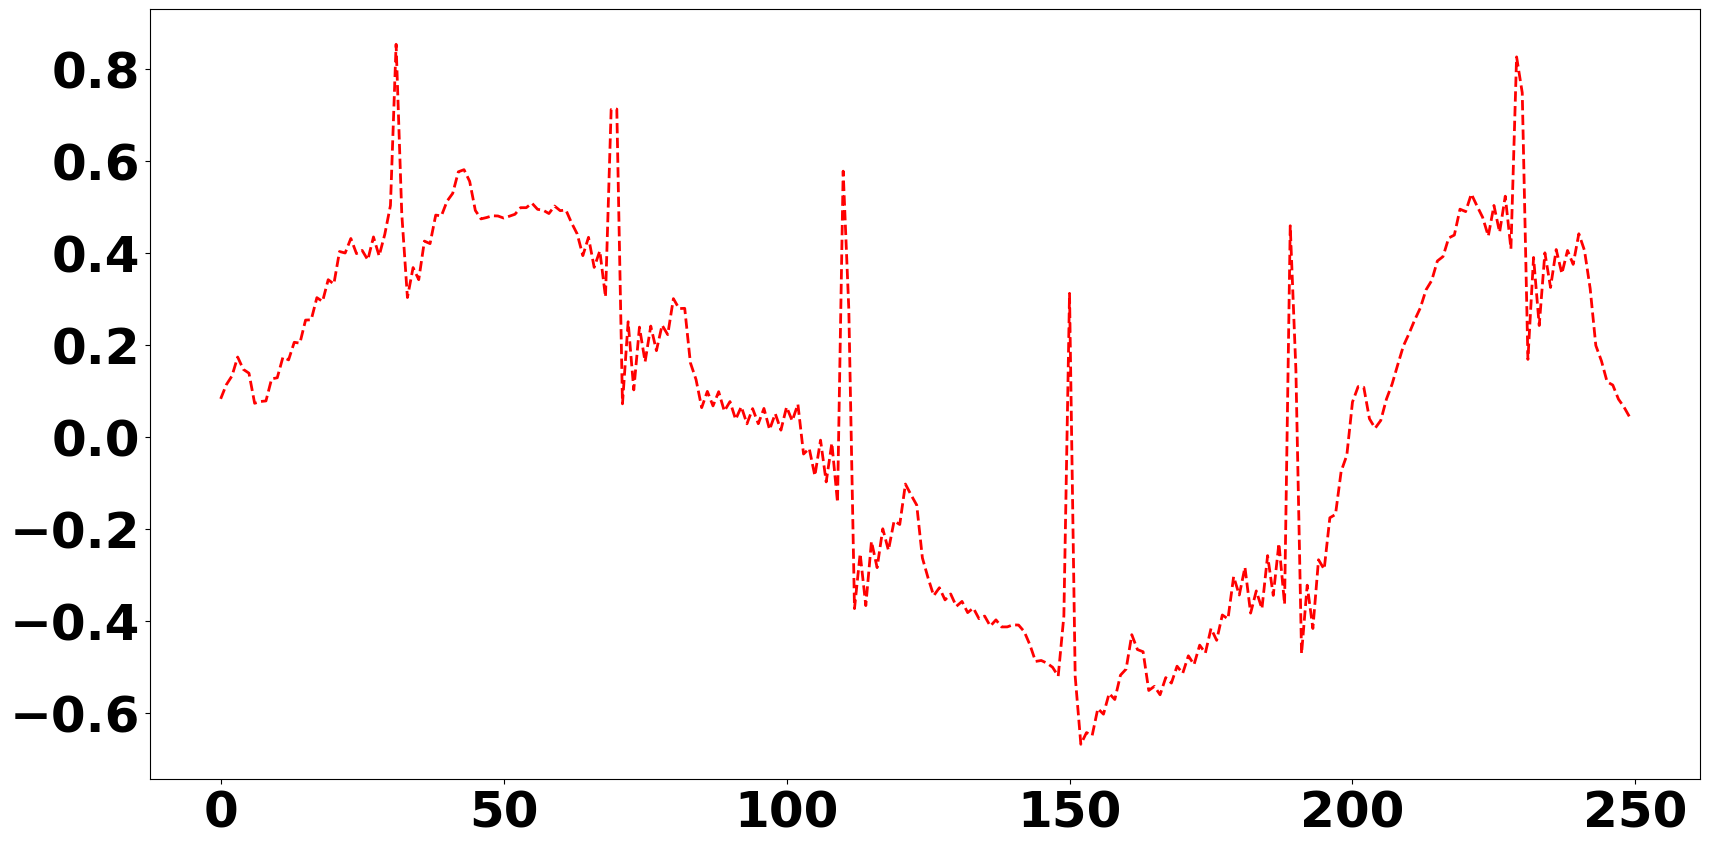

In [ ]:
rec = model_d([test_lr_n, None, None, None])[0]
fig = plt.figure(figsize = (20, 10))
plt.plot(rec[ch, :].cpu().detach().numpy(), "r--", linewidth = 2)
plt.xticks(fontsize=36)
plt.yticks(fontsize=36)
fig.savefig("rec_n_example.png", dpi=dpi)

In [18]:
from scipy import interpolate
def interpolate_single(signal, mode="cubic", fs_lr = 50, fs_hr = 500):
    t_low_res = np.arange(0, 5, 1/fs_lr)
    t_high_res = np.arange(0, 5, 1/fs_hr)  # 500 Hz sampling rate
    f_interp = interpolate.interp1d(t_low_res, signal, kind=mode, fill_value="extrapolate")
    signal_sr = f_interp(t_high_res)
    if isinstance(signal_sr, (np.ndarray, np.generic) ):
        signal_sr = torch.from_numpy(signal_sr)
    return signal_sr

torch.Size([1, 12, 250])


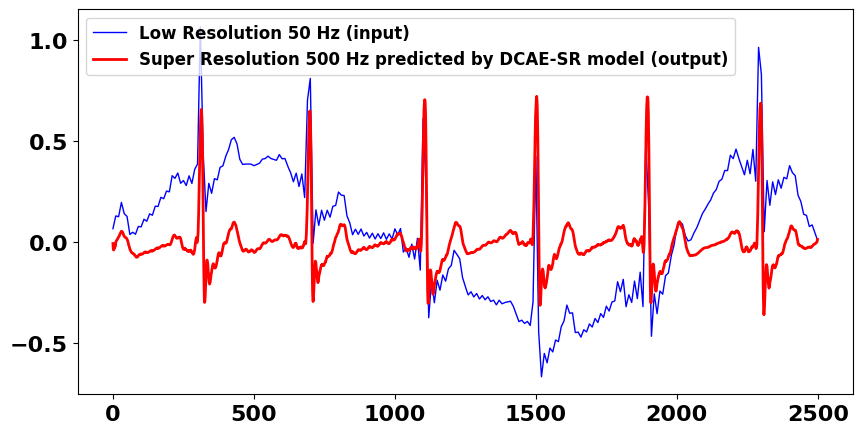

In [26]:
fig = plt.figure(figsize = (10, 5))
label = "STTC"
idx = 100
ch = 0
test_lr_n = dict_windows_train_lr_n[label][idx].to(device)
print(test_lr_n.shape)
test_lrup = interpolate_single(test_lr_n.cpu(), mode="linear")

sr = model_d([test_lr_n, None, None, None])[1]
test_lr_n = test_lr_n[0].cpu()
#plt.plot(test_hr[0, ch, :].cpu().detach().numpy(), "green", label = "High Resolution 500 Hz (target)", linewidth = 3)
plt.plot(test_lrup[0, ch, :], "blue", label = "Low Resolution 50 Hz (input)", linewidth = 1)
plt.plot(sr[ch, :].cpu().detach().numpy(), "red", label = "Super Resolution 500 Hz predicted by DCAE-SR model (output)", linewidth = 2)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = "12")

#fig.savefig("lr_hr_sr.png", dpi = 600)
#fig.savefig("lr_hr.png", dpi = 600)
fig.savefig("lr_sr.png", dpi = 600)

In [ ]:
def resample_signal(data, fs=50, nchs = 12, fin = 50):

    data = data.cpu()

    secs = data.shape[-1]/(fin)
    size = int(fs*secs)

    resampled_data = []
    for ch in range(nchs):
        temp = scipy.signal.resample(x=data[ch, :], num=size)
        resampled_data.append(torch.from_numpy(temp))

    resampled_data = torch.stack(resampled_data)

    return resampled_data

In [ ]:
len(np.arange(0, 5, 0.002))

2500

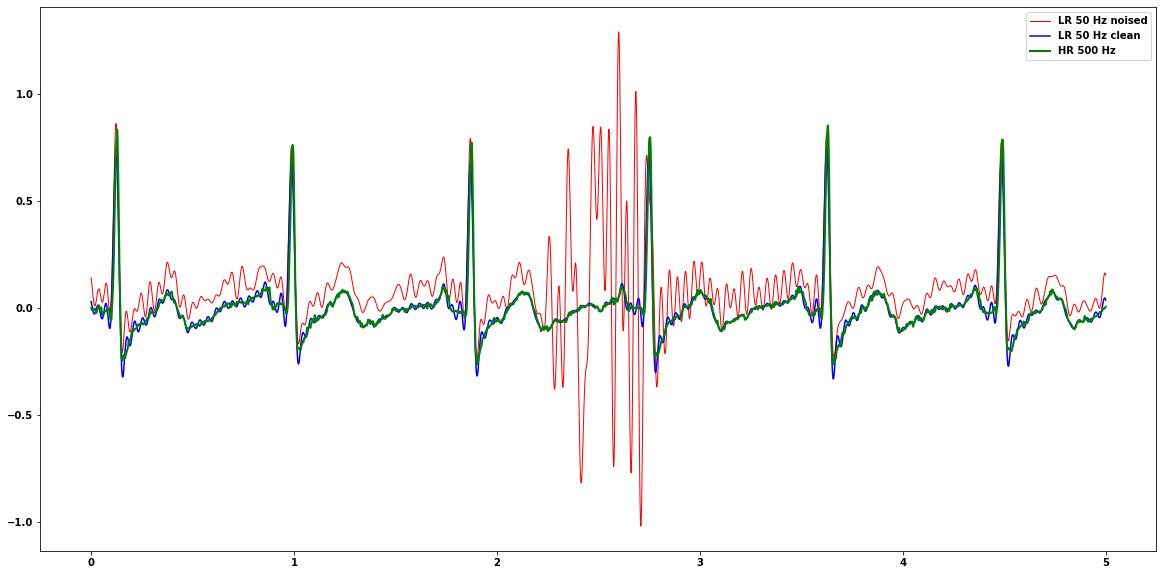

In [ ]:
import numpy as np

idx = 198
label = "NORM"
lr = dict_windows_train_lr[label][idx]
lr_noise = dict_windows_train_lr_n[label][idx]
hr = dict_windows_train_hr[label][idx]
ch = 0

lr = torch.squeeze(lr, dim = 0)
hr = torch.squeeze(hr, dim = 0).cpu()
lr_noise = torch.squeeze(lr_noise, dim = 0)

lr_up = resample_signal(lr, fs = 500, fin = 50)
lr_noise_up = resample_signal(lr_noise, fs = 500, fin = 50)
time = np.arange(0, 5, 0.002)


fig = plt.figure(figsize = (20, 10))
plt.plot(time, lr_noise_up[ch, :], "r", label = "LR 50 Hz noised", linewidth = 1)
plt.plot(time, lr_up[ch, :], "b", label = "LR 50 Hz clean", linewidth = 1.5)
plt.plot(time, hr[ch, :], "g", label = "HR 500 Hz", linewidth = 2)
plt.legend()

In [ ]:
fig.savefig("lrnoised_vs_lr_vs_hr.png", dpi = 600)

In [ ]:
import os
import torch

labels = list(map_superclass_rev.keys())
dict_windows_test_hr = {}
dict_windows_test_lr = {}
dict_windows_train_lr = {}
dict_windows_train_hr = {}
dict_windows_train_lr_n = {}
dict_windows_test_lr_n = {}

path = os.getcwd()+os.sep+"pt_data"+os.sep
for label in labels:

    if label == "All":
      continue
    print(label)
    filename = path + "test_{}_hr.pt".format(label)
    hr_data = torch.load(filename)
    dict_windows_test_hr[label] = hr_data

    filename = path + "test_{}_50.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_test_lr[label] = lr_data

    filename = path + "train_{}_hr.pt".format(label)
    hr_data = torch.load(filename)
    dict_windows_train_hr[label] = hr_data

    filename = path + "train_{}_50.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_train_lr[label] = lr_data

    filename = path + "test_{}_noisy.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_test_lr_n[label] = lr_data

    filename = path + "train_{}_noisy.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_train_lr_n[label] = lr_data

dict_windows_train = dict_windows_train_lr
dict_windows_test = dict_windows_test_lr

CD
HYP
MI
NORM
STTC


<ipython-input-109-036d6d59c969>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(3, 2, 1)


0
CD
1
HYP
2
MI
3
NORM
4
STTC
5


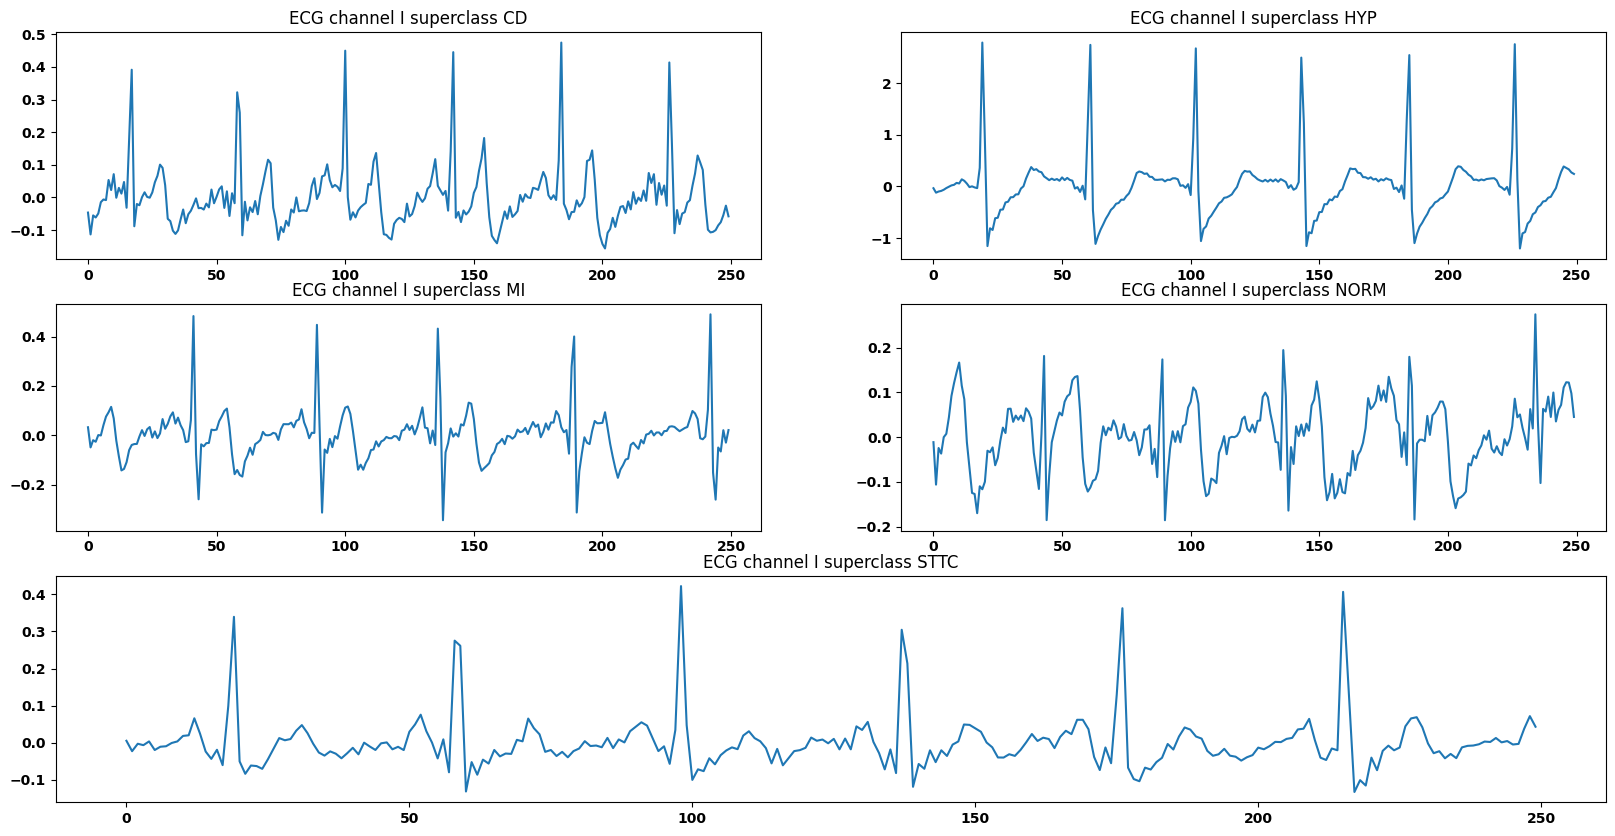

In [ ]:
from matplotlib import gridspec

fig1, axs = plt.subplots(figsize = (20, 10))
ch = 0
idx_signal = 0
idx = -1
ax1 = plt.subplot(3, 2, 1)
ax2 = plt.subplot(3, 2, 2)
ax3 = plt.subplot(3, 2, 3)
ax4 = plt.subplot(3, 2, 4)
ax5 = plt.subplot2grid(shape=(3, 2), loc=(2, 0), colspan=3)
axs = [ax1, ax2, ax3, ax4, ax5]

for i in range(3):
  for j in range(2):
    idx += 1
    print(idx)
    if idx == 5:
      break
    label = labels[idx]
    print(label)
    signal = dict_windows_test_lr[label][idx_signal, 0, ch, :].to("cpu").detach().numpy()
    ax = axs[idx]
    ax.title.set_text('ECG channel {} superclass {}'.format(channels_map[ch], label))
    ax.plot(signal)
plt.savefig("signals_example.png", format='png', dpi=100)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

X_train_lr_n = torch.cat([dict_windows_train_lr_n[label] for label in labels])
X_train_hr = torch.cat([dict_windows_train_hr[label] for label in labels])
X_test_lr_n = torch.cat([dict_windows_test_lr_n[label] for label in labels])
X_test_hr = torch.cat([dict_windows_test_hr[label] for label in labels])
X_train_lr_n.shape, X_test_lr_n.shape

(torch.Size([38460, 1, 12, 250]), torch.Size([4316, 1, 12, 250]))

In [ ]:
y_train = []
y_test = []
for label, xs in dict_windows_train_lr_n.items():
  n = len(xs)
  label_num = map_superclass_rev[label]
  for i in range(n):
    y_train.append(label_num)

for label, xs in dict_windows_test_lr_n.items():
  n = len(xs)
  label_num = map_superclass_rev[label]
  for i in range(n):
    y_test.append(label_num)

y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
y_train.shape, y_test.shape

(torch.Size([38460]), torch.Size([4316]))

In [ ]:
torch.save(X_train_lr_n, "x_train_lr_noisy.pt")
torch.save(X_train_hr, "x_train_hr_noisy.pt")
torch.save(X_test_lr_n, "x_test_lr_noisy.pt")
torch.save(X_test_hr, "x_test_hr_noisy.pt")

In [ ]:
torch.save(y_train, "y_train.pt")
torch.save(X_train_hr, "y_test.pt")

In [ ]:
device = "cuda:0"
model_d = torch.load("models/model_2_denoising_lrhr_v2.pt")

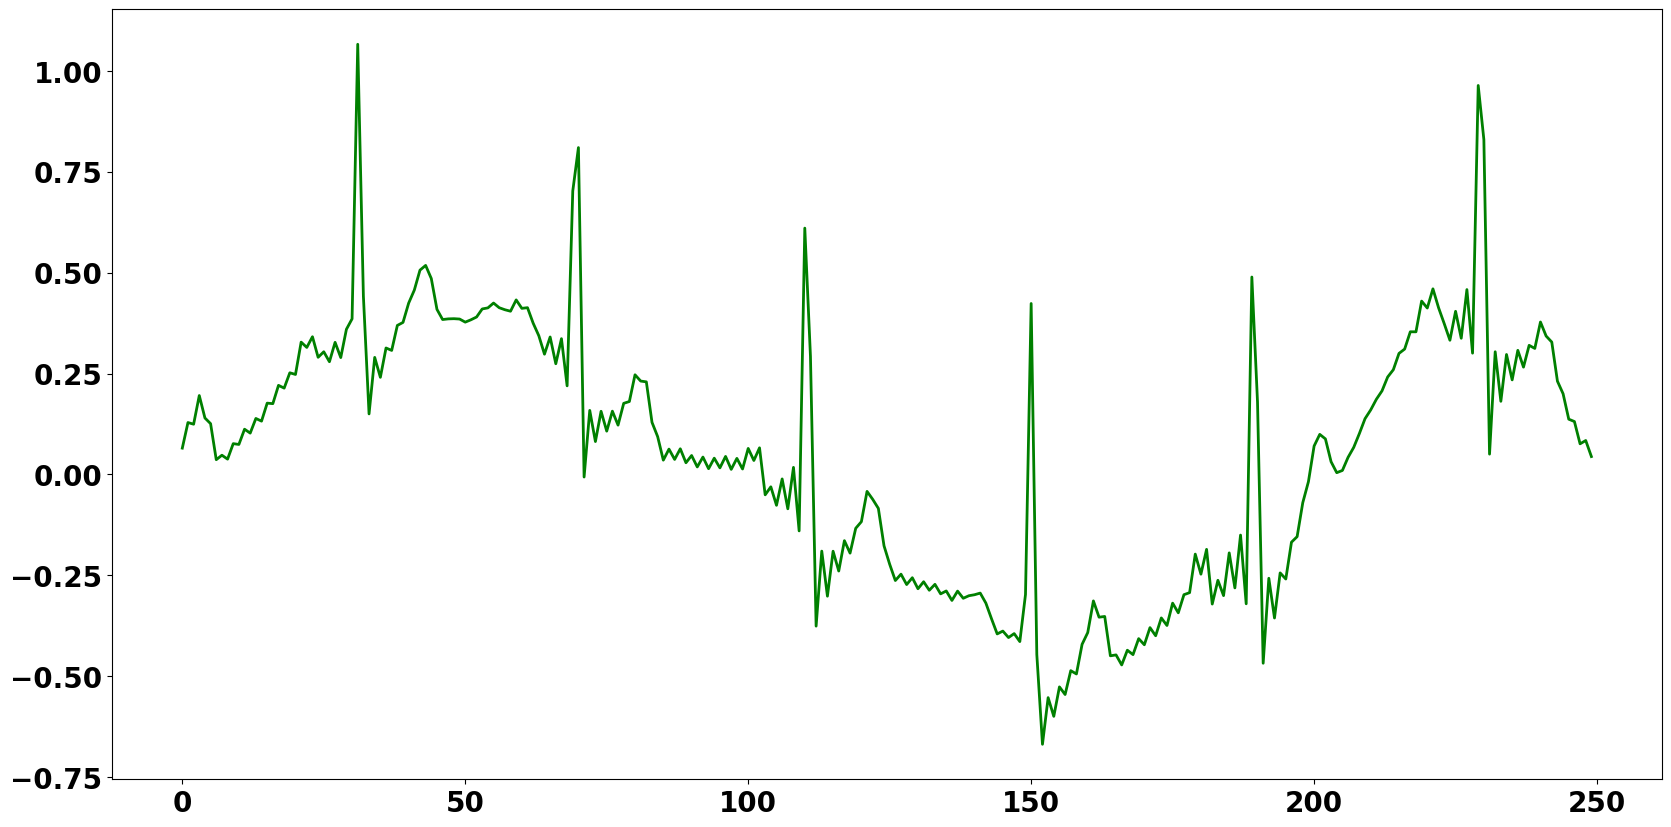

In [ ]:
idx = 100
ch = 0
label = "STTC"
test_lr_n = dict_windows_train_lr_n[label][idx]
test_lr = dict_windows_train_lr[label][idx]
fig = plt.figure(figsize = (20, 10))
plt.plot(test_lr_n[0, ch, :].cpu().detach().numpy(), "g", linewidth = 2)
#fig.savefig("lr_example.png", dpi=600)

In [ ]:
for block in model_d.decoder.decoder:
  block.last_tanh = False
for block in model_d.upsample.decoder:
  block.last_tanh = False

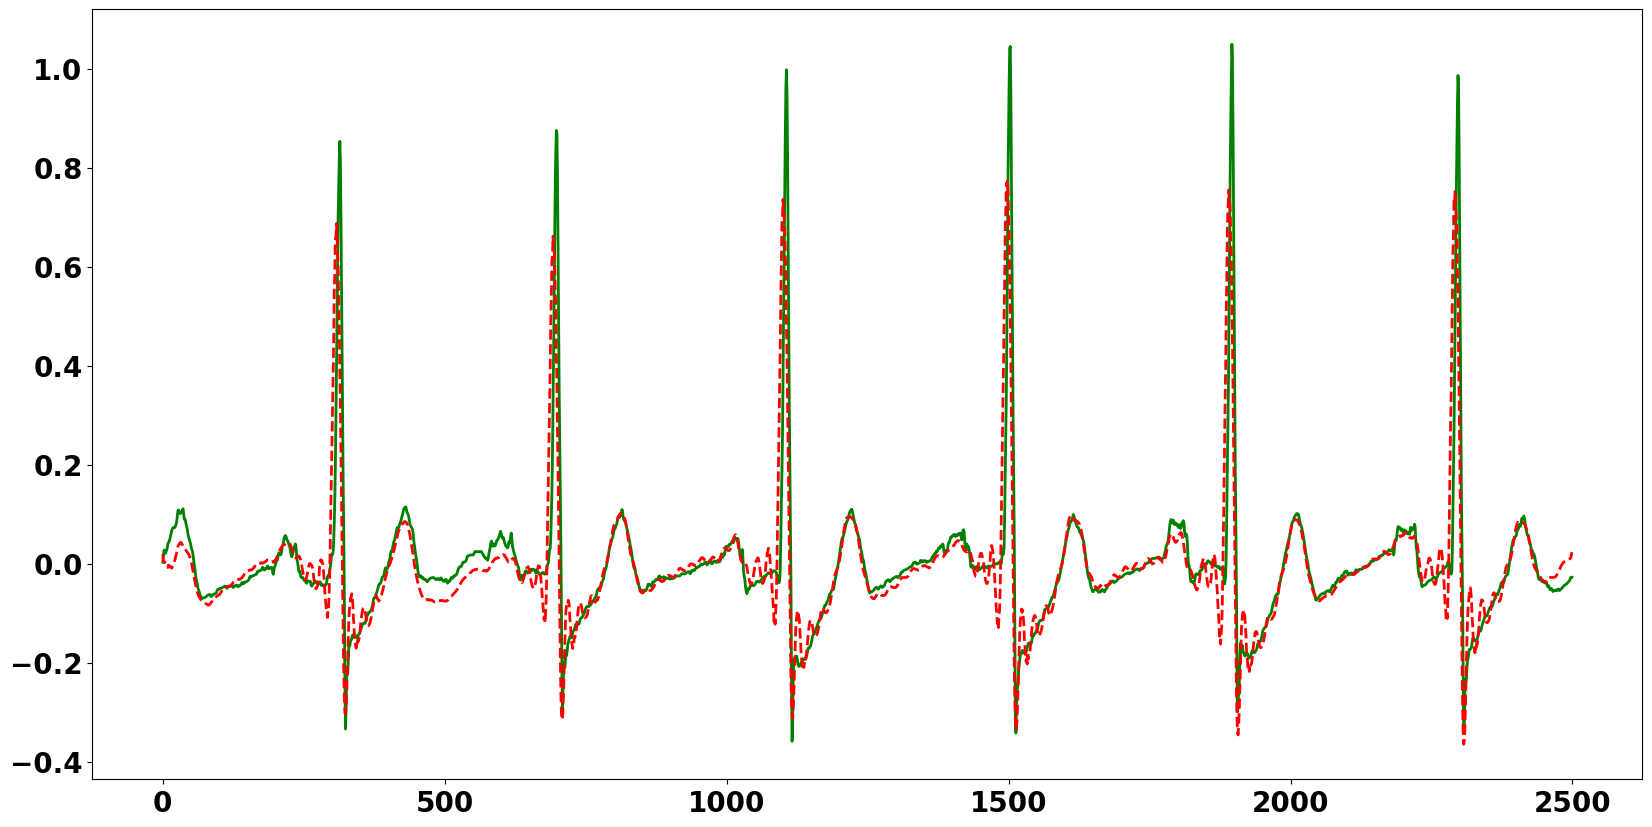

In [ ]:
fig = plt.figure(figsize = (20, 10))
sr = model_d([test_lr_n, None])[1]

hr = dict_windows_train_hr[label][idx]
plt.plot(hr[0, ch, :].cpu().detach().numpy(), "g", linewidth = 2)
plt.plot(sr[ch, :].cpu().detach().numpy(), "r--", linewidth = 2)

In [ ]:
import pandas as pd
import os

df = pd.read_csv(os.getcwd()+os.sep+"data"+os.sep+"ptbxl_database.csv")
df

ecg_id  patient_id    age  sex  height  weight  nurse  site  \
0           1     15709.0   56.0    1     NaN    63.0    2.0   0.0   
1           2     13243.0   19.0    0     NaN    70.0    2.0   0.0   
2           3     20372.0   37.0    1     NaN    69.0    2.0   0.0   
3           4     17014.0   24.0    0     NaN    82.0    2.0   0.0   
4           5     17448.0   19.0    1     NaN    70.0    2.0   0.0   
...       ...         ...    ...  ...     ...     ...    ...   ...   
21794   21833     17180.0   67.0    1     NaN     NaN    1.0   2.0   
21795   21834     20703.0  300.0    0     NaN     NaN    1.0   2.0   
21796   21835     19311.0   59.0    1     NaN     NaN    1.0   2.0   
21797   21836      8873.0   64.0    1     NaN     NaN    1.0   2.0   
21798   21837     11744.0   68.0    0     NaN     NaN    1.0   2.0   

           device       recording_date  ... validated_by_human  \
0       CS-12   E  1984-11-09 09:17:34  ...               True   
1       CS-12   E  1984-11-14 12:55:37  ...               True   
2       CS-12   E  1984-11-15 12:49:10  ...               True   
3       CS-12   E  1984-11-15 13:44:57  ...               True   
4       CS-12   E  1984-11-17 10:43:15  ...               True   
...           ...                  ...  ...                ...   
21794  AT-60    3  2001-05-31 09:14:35  ...               True   
21795  AT-60    3  2001-06-05 11:33:39  ...               True   
21796  AT-60    3  2001-06-08 10:30:27  ...               True   
21797  AT-60    3  2001-06-09 18:21:49  ...               True   
21798  AT-60    3  2001-06-11 16:43:01  ...               True   

       baseline_drift static_noise burst_noise electrodes_problems  \
0                 NaN    , I-V1,           NaN                 NaN   
1                 NaN          NaN         NaN                 NaN   
2                 NaN          NaN         NaN                 NaN   
3        , II,III,AVF          NaN         NaN                 NaN   
4       , III,AVR,AVF          NaN         NaN                 NaN   
...               ...          ...         ...                 ...   
21794             NaN   , alles,           NaN                 NaN   
21795             NaN          NaN         NaN                 NaN   
21796             NaN   , I-AVR,           NaN                 NaN   
21797             NaN          NaN         NaN                 NaN   
21798             NaN   , I-AVL,           NaN                 NaN   

       extra_beats  pacemaker  strat_fold                filename_lr  \
0              NaN        NaN           3  records100/00000/00001_lr   
1              NaN        NaN           2  records100/00000/00002_lr   
2              NaN        NaN           5  records100/00000/00003_lr   
3              NaN        NaN           3  records100/00000/00004_lr   
4              NaN        NaN           4  records100/00000/00005_lr   
...            ...        ...         ...                        ...   
21794          1ES        NaN           7  records100/21000/21833_lr   
21795          NaN        NaN           4  records100/21000/21834_lr   
21796          NaN        NaN           2  records100/21000/21835_lr   
21797         SVES        NaN           8  records100/21000/21836_lr   
21798          NaN        NaN           9  records100/21000/21837_lr   

                     filename_hr  
0      records500/00000/00001_hr  
1      records500/00000/00002_hr  
2      records500/00000/00003_hr  
3      records500/00000/00004_hr  
4      records500/00000/00005_hr  
...                          ...  
21794  records500/21000/21833_hr  
21795  records500/21000/21834_hr  
21796  records500/21000/21835_hr  
21797  records500/21000/21836_hr  
21798  records500/21000/21837_hr  

[21799 rows x 28 columns]

In [ ]:
df_statements = pd.read_csv(os.getcwd()+os.sep+"data"+os.sep+"scp_statements.csv")
df_statements

Unnamed: 0                                        description  diagnostic  \
0         NDT                     non-diagnostic T abnormalities         1.0   
1        NST_                            non-specific ST changes         1.0   
2         DIG                                   digitalis-effect         1.0   
3       LNGQT                                   long QT-interval         1.0   
4        NORM                                         normal ECG         1.0   
..        ...                                                ...         ...   
66       BIGU  bigeminal pattern (unknown origin, SV or Ventr...         NaN   
67       AFLT                                     atrial flutter         NaN   
68      SVTAC                       supraventricular tachycardia         NaN   
69       PSVT            paroxysmal supraventricular tachycardia         NaN   
70      TRIGU  trigeminal pattern (unknown origin, SV or Vent...         NaN   

    form  rhythm diagnostic_class diagnostic_subclass  \
0    1.0     NaN             STTC                STTC   
1    1.0     NaN             STTC                NST_   
2    1.0     NaN             STTC                STTC   
3    1.0     NaN             STTC                STTC   
4    NaN     NaN             NORM                NORM   
..   ...     ...              ...                 ...   
66   NaN     1.0              NaN                 NaN   
67   NaN     1.0              NaN                 NaN   
68   NaN     1.0              NaN                 NaN   
69   NaN     1.0              NaN                 NaN   
70   NaN     1.0              NaN                 NaN   

                                   Statement Category  \
0                   other ST-T descriptive statements   
1   Basic roots for coding ST-T changes and abnorm...   
2                   other ST-T descriptive statements   
3                   other ST-T descriptive statements   
4                                     Normal/abnormal   
..                                                ...   
66  Statements related to ectopic rhythm abnormali...   
67  Statements related to impulse formation (abnor...   
68  Statements related to impulse formation (abnor...   
69  Statements related to impulse formation (abnor...   
70  Statements related to ectopic rhythm abnormali...   

                        SCP-ECG Statement Description  AHA code  \
0                      non-diagnostic T abnormalities       NaN   
1                             non-specific ST changes     145.0   
2                           suggests digitalis-effect     205.0   
3                                    long QT-interval     148.0   
4                                          normal ECG       1.0   
..                                                ...       ...   
66  bigeminal pattern (unknown origin, SV or Ventr...       NaN   
67                                     atrial flutter      51.0   
68                       supraventricular tachycardia      55.0   
69            paroxysmal supraventricular tachycardia       NaN   
70  trigeminal pattern (unknown origin, SV or Vent...       NaN   

                    aECG REFID CDISC Code DICOM Code  
0                          NaN        NaN        NaN  
1         MDC_ECG_RHY_STHILOST        NaN        NaN  
2                          NaN        NaN        NaN  
3                          NaN        NaN        NaN  
4                          NaN        NaN    F-000B7  
..                         ...        ...        ...  
66                         NaN        NaN        NaN  
67        MDC_ECG_RHY_ATR_FLUT        NaN        NaN  
68        MDC_ECG_RHY_SV_TACHY        NaN   D3-31290  
69  MDC_ECG_RHY_SV_TACHY_PAROX        NaN        NaN  
70                         NaN        NaN        NaN  

[71 rows x 13 columns]

In [ ]:
df_statements["Unnamed: 0"]

0       NDT
1      NST_
2       DIG
3     LNGQT
4      NORM
      ...  
66     BIGU
67     AFLT
68    SVTAC
69     PSVT
70    TRIGU
Name: Unnamed: 0, Length: 71, dtype: object

In [ ]:
df.columns

Index(['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse',
       'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr'],
      dtype='object')

In [ ]:
df_statements[df_statements["diagnostic_class"] == label]

Unnamed: 0                                        description  diagnostic  \
0         NDT                     non-diagnostic T abnormalities         1.0   
1        NST_                            non-specific ST changes         1.0   
2         DIG                                   digitalis-effect         1.0   
3       LNGQT                                   long QT-interval         1.0   
9        ISC_                              non-specific ischemic         1.0   
13      ISCAL                    ischemic in anterolateral leads         1.0   
20      ISCIN                         ischemic in inferior leads         1.0   
23      ISCIL                    ischemic in inferolateral leads         1.0   
25      ISCAS                     ischemic in anteroseptal leads         1.0   
27      ISCLA                          ischemic in lateral leads         1.0   
29      ANEUR  ST-T changes compatible with ventricular aneurysm         1.0   
31         EL     electrolytic disturbance or drug (former EDIS)         1.0   
35      ISCAN                         ischemic in anterior leads         1.0   

    form  rhythm diagnostic_class diagnostic_subclass  \
0    1.0     NaN             STTC                STTC   
1    1.0     NaN             STTC                NST_   
2    1.0     NaN             STTC                STTC   
3    1.0     NaN             STTC                STTC   
9    NaN     NaN             STTC                ISC_   
13   NaN     NaN             STTC                ISCA   
20   NaN     NaN             STTC                ISCI   
23   NaN     NaN             STTC                ISCI   
25   NaN     NaN             STTC                ISCA   
27   NaN     NaN             STTC                ISCA   
29   NaN     NaN             STTC                STTC   
31   NaN     NaN             STTC                STTC   
35   NaN     NaN             STTC                ISCA   

                                   Statement Category  \
0                   other ST-T descriptive statements   
1   Basic roots for coding ST-T changes and abnorm...   
2                   other ST-T descriptive statements   
3                   other ST-T descriptive statements   
9   Basic roots for coding ST-T changes and abnorm...   
13                              ischemic ST-T changes   
20                              ischemic ST-T changes   
23                              ischemic ST-T changes   
25                              ischemic ST-T changes   
27                              ischemic ST-T changes   
29                  other ST-T descriptive statements   
31          physiopathological nature of ST-T changes   
35                              ischemic ST-T changes   

                        SCP-ECG Statement Description  AHA code  \
0                      non-diagnostic T abnormalities       NaN   
1                             non-specific ST changes     145.0   
2                           suggests digitalis-effect     205.0   
3                                    long QT-interval     148.0   
9                               ischemic ST-T changes     226.0   
13                             in anterolateral leads       NaN   
20                                  in inferior leads       NaN   
23                             in inferolateral leads       NaN   
25                              in anteroseptal leads       NaN   
27                                   in lateral leads       NaN   
29  ST-T changes compatible with ventricular aneurysm     227.0   
31          compatible with electrolyte abnormalities       NaN   
35                                  in anterior leads       NaN   

              aECG REFID CDISC Code DICOM Code  
0                    NaN        NaN        NaN  
1   MDC_ECG_RHY_STHILOST        NaN        NaN  
2                    NaN        NaN        NaN  
3                    NaN        NaN        NaN  
9                    NaN        NaN        NaN  
13                   NaN        NaN        NaN  
20

In [ ]:
from ast import literal_eval

def find_patient(df, df_statements, label, number, test = True):

  if test:
    patients = df[df["strat_fold"] == 9]
  else:
    patients = df[df["strat_fold"] != 9]

  scp_codes = df_statements[df_statements["diagnostic_class"] == label]["Unnamed: 0"].values
  print(scp_codes)
  count = 0
  for index, patient in patients.iterrows():
    scp_code = patient["scp_codes"]
    scp_code = literal_eval(scp_code)
    if isinstance(scp_code, dict):
      codes = scp_code.keys()
      #print(codes)
      for code in codes:
        #print(code)
        if code in scp_codes:
          print(code)
          if count == 0:
            count+=1
          else:
            count+=2
          print(count)
          break
      if count >= number:
        return patient

  return patient

In [ ]:
label = "STTC"
idx = 100
test_lr = dict_windows_train_lr[label][idx]
patient = find_patient(df, df_statements, label, idx, test = False)
patient

['NDT' 'NST_' 'DIG' 'LNGQT' 'ISC_' 'ISCAL' 'ISCIN' 'ISCIL' 'ISCAS' 'ISCLA'
 'ANEUR' 'EL' 'ISCAN']
NDT
1
NDT
3
NDT
5
ISCAL
7
NDT
9
NDT
11
NDT
13
ISCAL
15
ISCLA
17
NDT
19
NST_
21
ISC_
23
ISCAL
25
ISCAL
27
ISCAL
29
ANEUR
31
NDT
33
NDT
35
ISCIL
37
LNGQT
39
NDT
41
NST_
43
ISC_
45
ISC_
47
ISC_
49
NDT
51
ISC_
53
ISC_
55
ISCIN
57
ISC_
59
ISC_
61
ISC_
63
NDT
65
NDT
67
ISC_
69
ISC_
71
NDT
73
LNGQT
75
EL
77
NDT
79
NDT
81
ISC_
83
NDT
85
NDT
87
NDT
89
ISC_
91
ISC_
93
NST_
95
NDT
97
NDT
99
NDT
101


ecg_id                                                             369
patient_id                                                     15251.0
age                                                               55.0
sex                                                                  1
height                                                             NaN
weight                                                            63.0
nurse                                                              0.0
site                                                               0.0
device                                                       CS-12   E
recording_date                                     1986-11-21 10:33:37
report                          sinusrhythmus linkstyp qt-verlÄngerung
scp_codes                                    {'NDT': 100.0, 'SR': 0.0}
heart_axis                                                         LAD
infarction_stadium1                                                NaN
infarc

In [ ]:
def load_raw_data(filename):
    signal, meta = wfdb.rdsamp(filename)
    signal = signal.T
    return signal, meta

In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/ECG_SuperResolution/data/PTBXL/rawdata/records100/21000"

21000_lr.dat  21120_lr.dat  21240_lr.dat  21360_lr.dat	21480_lr.dat  21600_lr.dat  21720_lr.dat
21000_lr.hea  21120_lr.hea  21240_lr.hea  21360_lr.hea	21480_lr.hea  21600_lr.hea  21720_lr.hea
21001_lr.dat  21121_lr.dat  21241_lr.dat  21361_lr.dat	21481_lr.dat  21601_lr.dat  21721_lr.dat
21001_lr.hea  21121_lr.hea  21241_lr.hea  21361_lr.hea	21481_lr.hea  21601_lr.hea  21721_lr.hea
21002_lr.dat  21122_lr.dat  21242_lr.dat  21362_lr.dat	21482_lr.dat  21602_lr.dat  21722_lr.dat
21002_lr.hea  21122_lr.hea  21242_lr.hea  21362_lr.hea	21482_lr.hea  21602_lr.hea  21722_lr.hea
21003_lr.dat  21123_lr.dat  21243_lr.dat  21363_lr.dat	21483_lr.dat  21603_lr.dat  21723_lr.dat
21003_lr.hea  21123_lr.hea  21243_lr.hea  21363_lr.hea	21483_lr.hea  21603_lr.hea  21723_lr.hea
21004_lr.dat  21124_lr.dat  21244_lr.dat  21364_lr.dat	21484_lr.dat  21604_lr.dat  21724_lr.dat
21004_lr.hea  21124_lr.hea  21244_lr.hea  21364_lr.hea	21484_lr.hea  21604_lr.hea  21724_lr.hea
21005_lr.dat  21125_lr.dat  21245_lr.dat

In [ ]:
import os
cwd = os.getcwd()
sep = os.sep

print(patient)
filename = cwd + sep + "data" + sep + "PTBXL" + sep + "rawdata" + sep + patient[-2]
signal, meta = load_raw_data(filename)
signal, meta

ecg_id                                                             369
patient_id                                                     15251.0
age                                                               55.0
sex                                                                  1
height                                                             NaN
weight                                                            63.0
nurse                                                              0.0
site                                                               0.0
device                                                       CS-12   E
recording_date                                     1986-11-21 10:33:37
report                          sinusrhythmus linkstyp qt-verlÄngerung
scp_codes                                    {'NDT': 100.0, 'SR': 0.0}
heart_axis                                                         LAD
infarction_stadium1                                                NaN
infarc

(array([[ 0.944,  1.007,  0.046, ..., -0.054, -0.078, -0.088],
        [ 0.064, -0.239, -0.619, ...,  0.009, -0.019, -0.029],
        [-0.88 , -1.246, -0.665, ...,  0.063,  0.06 ,  0.059],
        ...,
        [ 0.4  ,  0.072, -0.484, ...,  0.06 ,  0.05 ,  0.039],
        [ 0.382,  0.049, -0.433, ...,  0.052,  0.043,  0.038],
        [ 0.292,  0.028, -0.345, ..., -0.004, -0.018, -0.032]]),
 {'fs': 100,
  'sig_len': 1000,
  'n_sig': 12,
  'base_date': None,
  'base_time': None,
  'units': ['mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV'],
  'sig_name': ['I',
   'II',
   'III',
   'AVR',
   'AVL',
   'AVF',
   'V1',
   'V2',
   'V3',
   'V4',
   'V5',
   'V6'],
  'comments': []})

In [ ]:
signal.shape

(12, 1000)

In [ ]:
from functions import *
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
font = {'family' : '',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

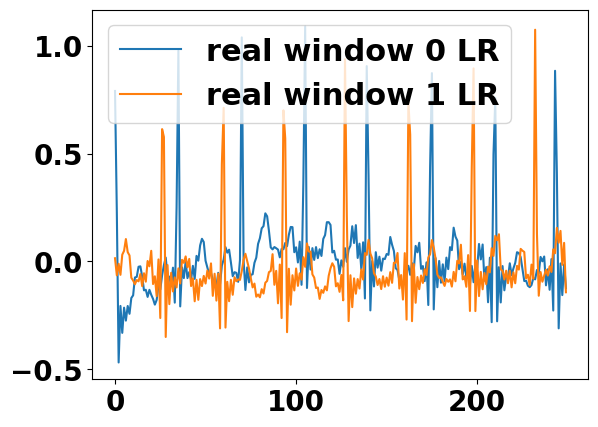

In [ ]:
downsignal = resample_signal(torch.from_numpy(signal), fs=50, fin=100)
signal_filt = myfilter(0.05, downsignal)
fs = 50
windows = sliding_window(signal_filt, size = fs*5, stride = fs*5)
#label_num = map_superclass_rev[label]
#windows, _ = split_windows([signal_filt], [label_num], fs*5, stride = fs*5)
#windows = [window.squeeze(dim=0) for window in windows]

plt.figure()
plt.plot(windows[0][ch, :].to("cpu").detach().numpy(), label = "real window 0 LR")
plt.plot(windows[1][ch, :].to("cpu").detach().numpy(), label = "real window 1 LR")
plt.legend()

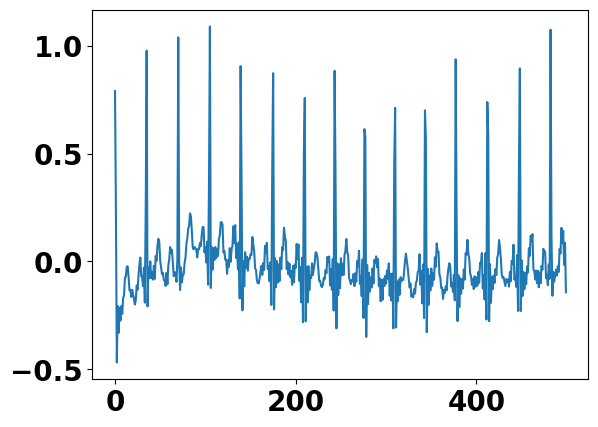

In [ ]:
plt.plot(signal_filt[ch, :])

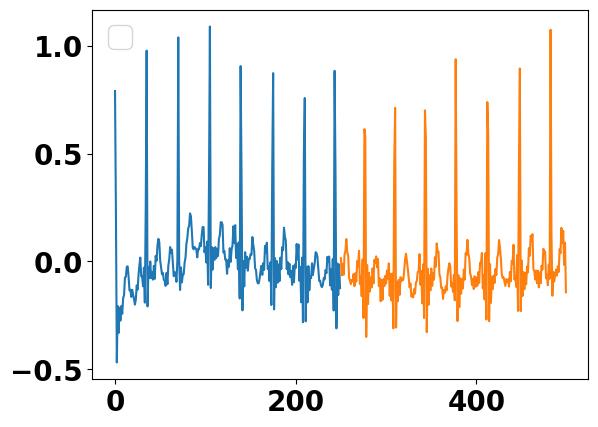

In [ ]:
plt.plot(np.arange(0, 250), windows[0][ch, :].to("cpu").detach().numpy())
plt.plot(np.arange(250, 500), windows[1][ch, :].to("cpu").detach().numpy())
plt.legend()

In [ ]:
idx

100

In [ ]:
if idx%2 == 0:
  window_idx = 1
else:
  window_idx = 0
window_idx

1

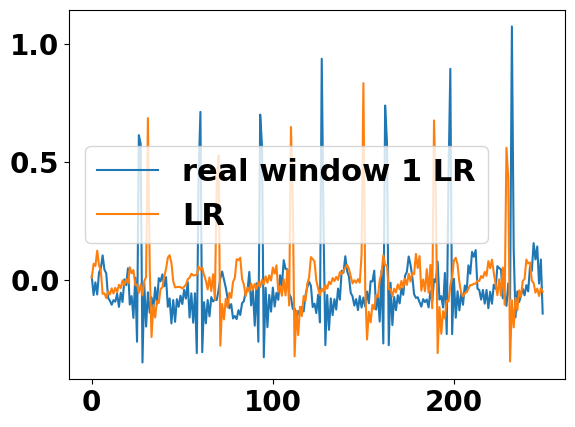

In [ ]:
plt.plot(windows[window_idx][ch, :].to("cpu").detach().numpy(), label = "real window {} LR".format(window_idx))
plt.plot(test_lr[0, ch].to("cpu").detach().numpy(), label = "LR")
plt.legend()

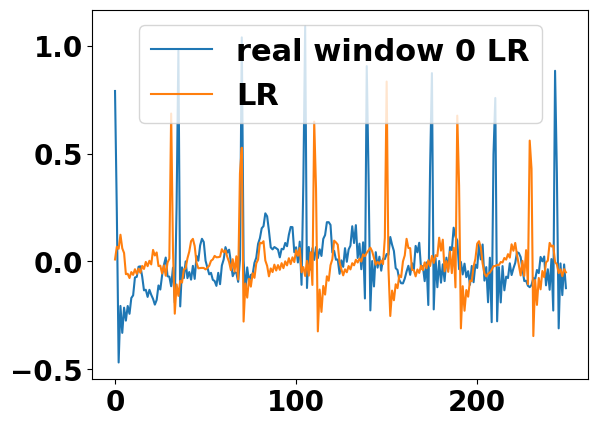

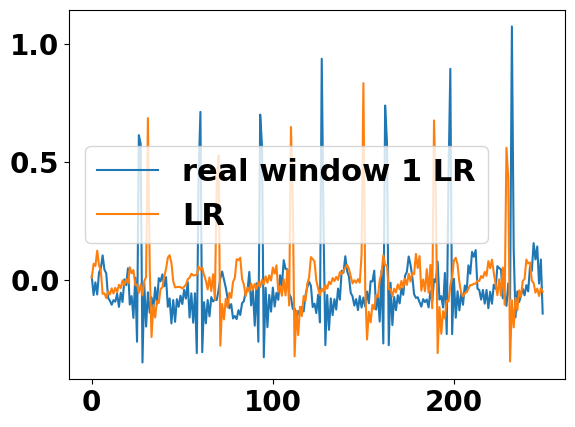

In [ ]:
plt.plot(windows[0][ch, :].to("cpu").detach().numpy(), label = "real window 0 LR")
plt.plot(test_lr[0, ch].to("cpu").detach().numpy(), label = "LR")
plt.legend()


plt.figure()
plt.plot(windows[1][ch, :].to("cpu").detach().numpy(), label = "real window 1 LR")
plt.plot(test_lr[0, ch].to("cpu").detach().numpy(), label = "LR")
plt.legend()

In [ ]:
"""
end = False
filenames = df["filename_lr"].values
for i, filename in enumerate(filenames):
  print("\r ", i, "/", len(filenames), end = "")
  filepath = cwd + sep + "data" + sep + "PTBXL" + sep + "rawdata" + sep + filename
  signal, meta = load_raw_data(filepath)
  downsignal = resample_signal(torch.from_numpy(signal), fs=50, fin=100)
  signal_filt = myfilter(0.05, downsignal)
  windows = sliding_window(signal_filt, size = 250, stride = 250)
  windows = torch.from_numpy(np.array(windows)).to(device)
  for window_idx, window in enumerate(windows):
    if torch.equal(window, test_lr):
      end = True
      break
    del window
  if end:
    break
  else:
    del signal
    del meta
    del downsignal
    del signal_filt
    del windows
filename, signal_filt.shape, window_idx, meta
"""

'\nend = False\nfilenames = df["filename_lr"].values\nfor i, filename in enumerate(filenames):\n  print("\r ", i, "/", len(filenames), end = "")\n  filepath = cwd + sep + "data" + sep + "PTBXL" + sep + "rawdata" + sep + filename\n  signal, meta = load_raw_data(filepath)\n  downsignal = resample_signal(torch.from_numpy(signal), fs=50, fin=100)\n  signal_filt = myfilter(0.05, downsignal)\n  windows = sliding_window(signal_filt, size = 250, stride = 250)\n  windows = torch.from_numpy(np.array(windows)).to(device)\n  for window_idx, window in enumerate(windows):\n    if torch.equal(window, test_lr):\n      end = True\n      break\n    del window \n  if end:\n    break\n  else:\n    del signal\n    del meta\n    del downsignal\n    del signal_filt\n    del windows \nfilename, signal_filt.shape, window_idx, meta\n'

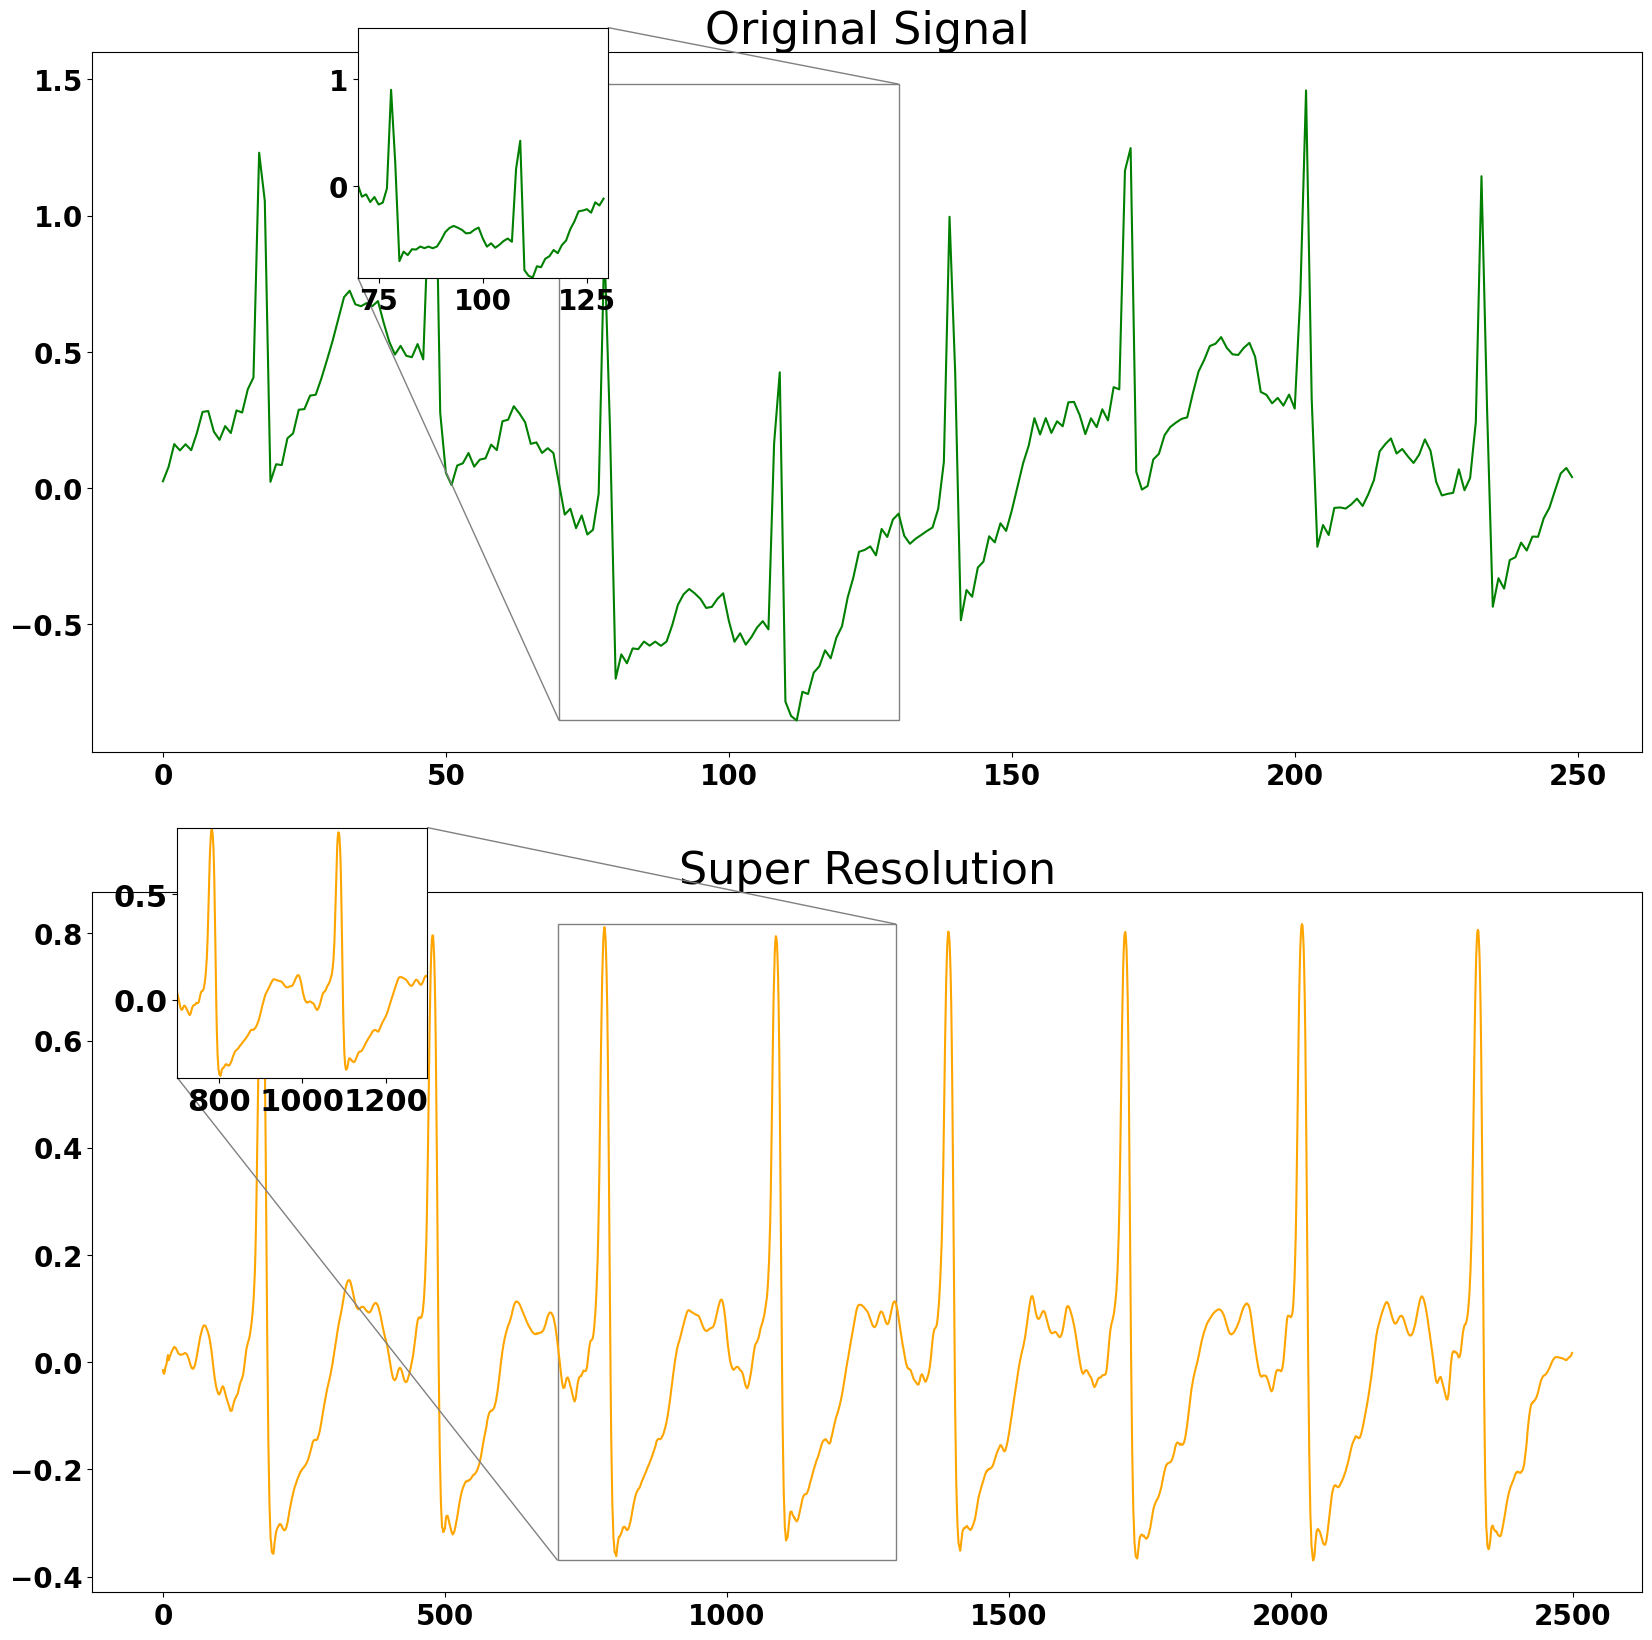

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

idx = 100
label = "MI"

to_predict_lr = dict_windows_test_lr_n[label][idx][0, :, :]
to_predict_hr = dict_windows_test_hr[label][idx][0, :, :]

channel = "All Channels"
fig, axs = plt.subplots(2, figsize=(20, 20))
if channel == "All Channels":
  channel_m = channel
else:
  channel_m = channels_map[channel]
#fig.suptitle("Super resoluted ECG signal, channel {}".format(channel_m), fontsize = 36)


model = model.to(device)
model.eval()
pred = model([to_predict_lr.to(device), None, None, None])
n1 = to_predict_lr.shape[-1]
t1 = np.arange(0, n1, 1)
sig_or = torch.squeeze(to_predict_lr).cpu().detach().numpy()
sig_sr = torch.squeeze(pred[1]).cpu().detach().numpy()
n2 = sig_sr.shape[-1]
t2 = np.arange(0, n2, 1)

for i in range(2):

    ax = axs[i]

    if i == 1:
        t = t2
        title = "Super Resolution"
        if channel != "All Channels":
            y = sig_sr[:]
        else:
            y = sig_sr[0, :]
        axins = inset_axes(ax, 2.5, 2.5, loc=1, bbox_to_anchor=(.3, 0.5),bbox_transform=fig.transFigure)
        color = "orange"
    else:
        t = t1
        title = "Original Signal"
        if channel != "All Channels":
            y = sig_or[:]
        else:
            y = sig_or[0, :]
        axins = inset_axes(ax, 2.5, 2.5, loc=2, bbox_to_anchor=(.25, 0.9),bbox_transform=fig.transFigure)
        color = "g"

    ax.plot(t, y, color)
    ax.title.set_text(title)
    ax.title.set_size(32)

    if i == 0:
        i1, i2 = 70, 130# specify the limits
    else:
        i1, i2 = 70*10, 130*10

    axins.plot(t[i1:i2], y[i1:i2], color)

    axins.set_xlim(t[i1], t[i2]) # apply the x-limits
    axins.set_ylim(min(y), max(y)) # apply the y-limits

    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")

plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.show()

In [ ]:
fig.savefig("super_resolution_zoom.jpg", dpi=600)